Competitions included in this report:


In [1]:
# Enable PEP8 code checking.
%load_ext pycodestyle_magic

In [2]:
%flake8_on --max_line_length 120

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import yaml

from football_data_api import data_fetchers
from footy import Footy
from footy.domain.Fixture import Fixture
from footy.domain.Team import Team

with open('footy.yml') as stream:
    footy_data = yaml.safe_load(stream.read())


def extract_team_names_from_matches(matches):
    team_names = []

    for match in matches:
        away_team_name = match['awayTeam']['name']
        home_team_name = match['homeTeam']['name']

        for team_name in [away_team_name, home_team_name]:
            if team_name not in team_names:
                team_names.append(team_name)

    return sorted(team_names)


def moving_average(x, w=3):
    if type(x) == list:
        x = np.array(x)
    a = (np.convolve(x, np.ones(w), 'valid') / w).tolist()
    return x.tolist()[0:w - 1] + a


def process_competition_page(competition_code):
    time.sleep(10)  # Throttle calls to the Football Data API
    # teams = []
    football_data_api = data_fetchers.CompetitionData()
    widget = footy_data['competitions'][competition_code]
    competition_name = widget['competition_name']
    football_data_api.competition = competition_name
    matches_data = football_data_api.get_info('matches')
    team_names = extract_team_names_from_matches(matches_data['matches'])
    match = matches_data['matches'][0]
    current_match_day = match['season']['currentMatchday']
    footy = Footy()
    total_goals_scored_by_home_team = 0
    total_goals_scored_by_away_team = 0
    total_games = 0

    for team_name in team_names:
        team = Team(team_name)
        footy.add_team(team)

    for match_day in range(0, current_match_day):
        fixture_params = []

        for match in matches_data['matches']:
            match_status = match['status']

            if match['matchday'] != match_day:
                continue
            elif match_status != 'FINISHED':
                continue
            elif match['stage'] != 'REGULAR_SEASON':
                continue

            total_games += 1
            home_team_name = match['homeTeam']['name']
            home_team = footy.get_team(home_team_name)
            home_team_goals = match['score']['fullTime']['homeTeam']
            away_team_goals = match['score']['fullTime']['awayTeam']
            goals_for = match['score']['fullTime']['homeTeam']
            total_goals_scored_by_home_team += goals_for
            goals_for += home_team.goals_for()
            goals_against = match['score']['fullTime']['awayTeam']
            total_goals_scored_by_away_team += goals_against
            goals_against += home_team.goals_against()
            home_games = home_team.home_games() + 1
            points = home_team.points()

            if home_team_goals > away_team_goals:
                points += 3
                outcome = [1, 0, 0]
            elif home_team_goals == away_team_goals:
                points += 1
                outcome = [0, 1, 0]
            else:
                outcome = [0, 0, 1]

            home_team.goals_for(goals_for)
            home_team.goals_against(goals_against)
            home_team.home_games(home_games)
            home_team.points(points)

            away_team_name = match['awayTeam']['name']
            away_team = footy.get_team(away_team_name)
            fixture_params.append((home_team_name, away_team_name))
            goals_for = away_team_goals
            goals_for += away_team.goals_for()
            goals_against = match['score']['fullTime']['awayTeam']
            goals_against += away_team.goals_against()
            away_games = away_team.away_games() + 1
            points = away_team.points()

            if home_team_goals < away_team_goals:
                points += 3
            elif home_team_goals == away_team_goals:
                points += 1

            away_team.goals_for(goals_for)
            away_team.goals_against(goals_against)
            away_team.away_games(away_games)
            away_team.points(points)

            footy.add_team(home_team)
            footy.add_team(away_team)
            total_goals_scored_by_home_team += home_team_goals
            total_goals_scored_by_away_team += away_team_goals

        if total_games > 0:
            average_goals_scored_by_a_home_team = \
                total_goals_scored_by_home_team
            average_goals_scored_by_a_home_team /= total_games
            footy.average_goals_scored_by_a_home_team(
                average_goals_scored_by_a_home_team)

            average_goals_scored_by_an_away_team = \
                total_goals_scored_by_away_team
            average_goals_scored_by_an_away_team /= total_games
            footy.average_goals_scored_by_an_away_team(
                average_goals_scored_by_an_away_team)

        for team_name in footy.get_team_names():
            team = footy.get_team(team_name)
            attack_strength = footy.attack_strength(team)
            defence_factor = footy.defence_factor(team)
            team.historic_attack_strength(attack_strength)
            team.historic_defence_factor(defence_factor)
            footy.add_team(team)

        for fixture_param in fixture_params:
            (home_team_name, away_team_name) = fixture_param
            home_team = footy.get_team(home_team_name)
            away_team = footy.get_team(away_team_name)
            fixture = footy.fixture(home_team, away_team)

            y_prob = fixture.outcome_probabilities()

            if y_prob is not None:
                brier_score = footy.brier_score(outcome, y_prob)
                home_team.historic_briers_score(brier_score)
                footy.add_team(home_team)
                away_team.historic_briers_score(brier_score)
                footy.add_team(away_team)

    upcoming_fixtures = []

    for match in matches_data['matches']:
        if match['matchday'] == current_match_day and match['stage'] == 'REGULAR_SEASON':
            away_team_name = match['awayTeam']['name']
            home_team_name = match['homeTeam']['name']
            away_team = footy.get_team(away_team_name)
            home_team = footy.get_team(home_team_name)
            utc_start = match['utcDate']
            upcoming_fixtures.append(footy.fixture(home_team, away_team, utc_start=utc_start))

    return footy, upcoming_fixtures


def show_league_table(footy):
    df = footy.dataframe().rename(columns={
        'attack_strength': 'AS',
        'away_games': 'AG',
        'defence_factor': 'DF',
        'goal_difference': 'GD',
        'goals_against': 'GA',
        'goals_for': 'GF',
        'home_games': 'HG',
        'points': 'PTS'
    })
    print(df)
    print('')
    print('Keys:')
    print(' - AS = Attack Strength')
    print(' - AG = Away Games Played')
    print(' - DF = Defence Factor')
    print(' - GA = Goals Against')
    print(' - GD = Goal Difference')
    print(' - GF = Goals For')
    print(' - HG = Home Games')
    print(' - PTS = Points')


def show_team(team):
    team_name = team.team_name()
    outcomes_briers_scores = team.historic_briers_score()

    if len(outcomes_briers_scores) >= 3:
        briers_scores_outcomes_ma3 = moving_average(outcomes_briers_scores)
    else:
        briers_scores_outcomes_ma3 = None

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(team_name)

    if len(outcomes_briers_scores) > 0:
        label = f'Briers Score: {outcomes_briers_scores[-1]}'
    else:
        label = 'Briers Score'

    ax1.plot(outcomes_briers_scores, label=label)

    if briers_scores_outcomes_ma3:
        ax1.plot(briers_scores_outcomes_ma3, label='Briers Score MA(3)')

    ax1.legend()
    ax1.set_ylim(0.0, 2.0)
    ax1.set(xlabel='Games', title='Briers Scores')

    attack_strengths = team.historic_attack_strength()
    defence_factors = team.historic_defence_factor()
    ax2.plot(attack_strengths, label='Attack Strengths')
    ax2.plot(defence_factors, label='Defence Factors')
    ax2.legend()
    ax2.set(xlabel='Games', title='Attack Strengh/Defence Factor')
    ax2.grid()


def show_upcoming_fixtures(fixtures):
    if len(fixtures) == 0:
        print('No upcoming fixtures or not enough data.')
        return

    fixtures.sort(reverse=True)

    for fixture in fixtures:
        outcome_probabilities = fixture.outcome_probabilities()
        if not outcome_probabilities:
            continue

        width = 0.3
        utc_start = fixture.utc_start
        home_team = fixture.home_team
        home_team_name = home_team.team_name()
        away_team = fixture.away_team
        away_team_name = away_team.team_name()
        # final_score_probabilities = fixture.final_score_probabilities()
        away_team_goals_probability = fixture.away_team_goals_probability()
        home_team_goals_probability = fixture.home_team_goals_probability()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{utc_start} {home_team_name} v {away_team_name}')
        ax1.bar(np.arange(len(home_team_goals_probability)),
                home_team_goals_probability, width=width, label=home_team_name)
        ax1.bar(np.arange(len(away_team_goals_probability)) + width,
                away_team_goals_probability, width=width, label=away_team_name)
        ax1.set(xlabel='Goals', ylabel='Probability', title='Goal Probability')
        ax1.legend()

        labels = [f'{home_team_name} Win', 'Draw', f'{away_team_name} Win']
        ax2.pie(outcome_probabilities, labels=labels, autopct='%1.1f%%',
                shadow=True, startangle=90, labeldistance=None, normalize=True)
        ax2.legend(loc="lower right")
        # Equal aspect ratio ensures that pie is drawn as a circle.
        ax2.axis('equal')
        ax2.set(title='Outcome Probability')
        plt.show()
        show_team(home_team)
        show_team(away_team)


for competition_code in footy_data['competitions']:
    widget = footy_data['competitions'][competition_code]
    competition_name = widget['competition_name']
    bbc_table = widget['bbc_table_site']
    country = widget['country']
    print(f'- {competition_name} ({country}) {bbc_table}')

- Bundesliga (DE) https://www.bbc.co.uk/sport/football/german-bundesliga/table
- Série A (BR) https://www.bbc.co.uk/sport/football/brazilian-league/table
- Eredivisie (NE) https://www.bbc.co.uk/sport/football/dutch-eredivisie/table
- Championship (UK) https://www.bbc.co.uk/sport/football/championship/table
- Ligue 1 (FR) https://www.bbc.co.uk/sport/football/french-ligue-one/table
- Primera Division (ES) https://www.bbc.co.uk/sport/football/spanish-la-liga/table
- Premier League (UK) https://www.bbc.co.uk/sport/football/premier-league/table
- Primeira Liga (PT) https://www.bbc.com/sport/football/portuguese-primeira-liga/table
- Serie A (IT) https://www.bbc.co.uk/sport/football/italian-serie-a/table


![http://creativecommons.org/licenses/by-sa/4.0/](images/cc-by-sa-80x15.png)

This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# German Bundesliga

## League Table

In [4]:
footy, fixtures = process_competition_page('BL1')
show_league_table(footy)

                   team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0          FC Bayern München  71  43  12  12  28   55  1.97  1.26
1                 RB Leipzig  46  31  12  12  15   53  1.28  0.91
2              VfL Wolfsburg  38  27  11  13  11   45  1.06  0.79
3        Eintracht Frankfurt  47  38  12  12   9   43  1.31  1.12
4        Bayer 04 Leverkusen  42  35  12  12   7   40  1.17  1.03
5          Borussia Dortmund  50  39  11  13  11   39  1.39  1.15
6         1. FC Union Berlin  36  27  12  12   9   35  1.00  0.79
7                SC Freiburg  37  33  13  11   4   34  1.03  0.97
8   Borussia Mönchengladbach  40  36  13  11   4   33  1.11  1.06
9              VfB Stuttgart  45  43  11  13   2   33  1.25  1.26
10       TSG 1899 Hoffenheim  39  34  12  12   5   30  1.08  1.00
11          SV Werder Bremen  29  32  11  13  -3   30  0.81  0.94
12               FC Augsburg  24  32  12  12  -8   26  0.67  0.94
13                1. FC Köln  22  31  12  12  -9   22  0.61  0.91
14        

## Upcoming Fixtures

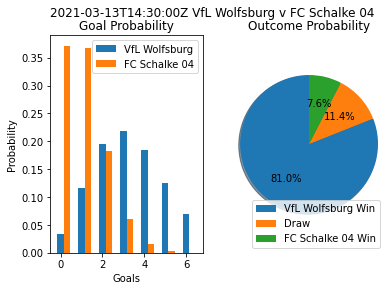

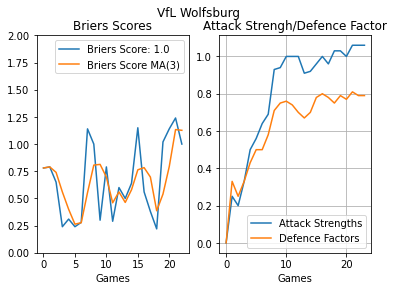

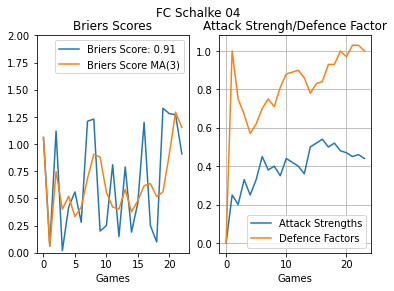

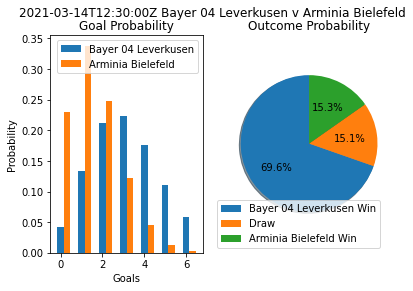

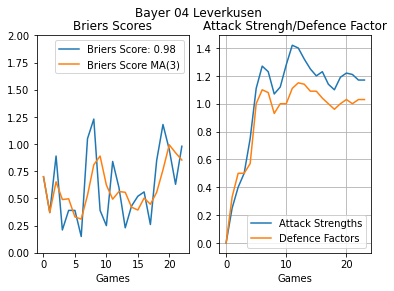

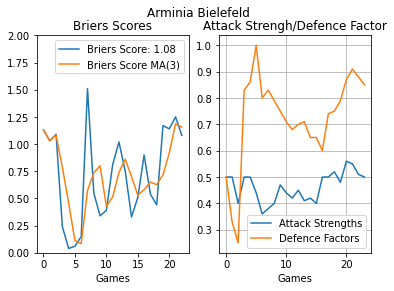

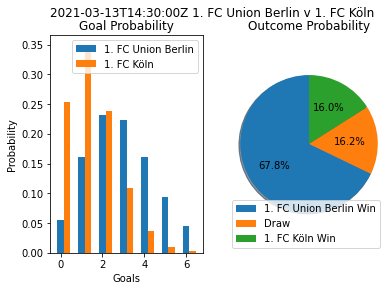

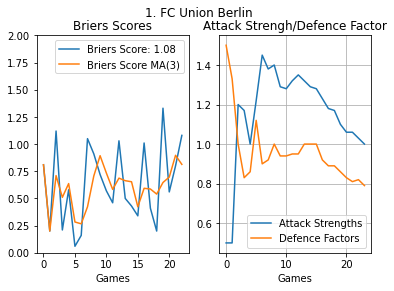

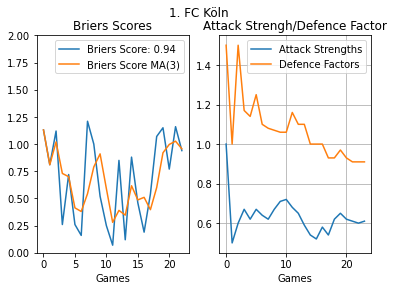

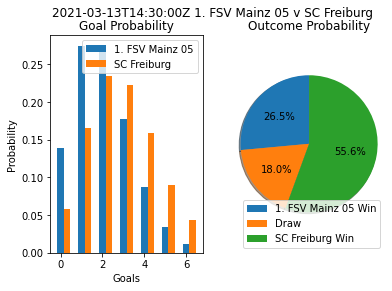

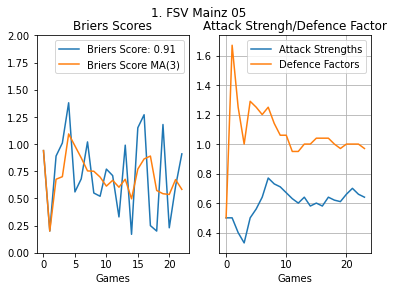

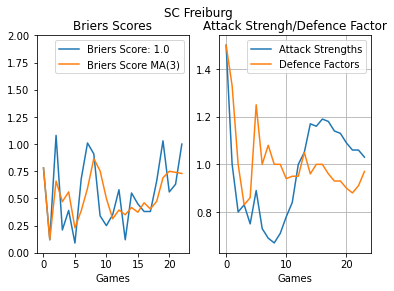

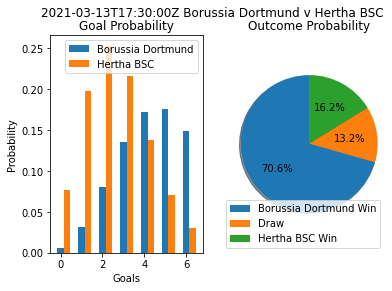

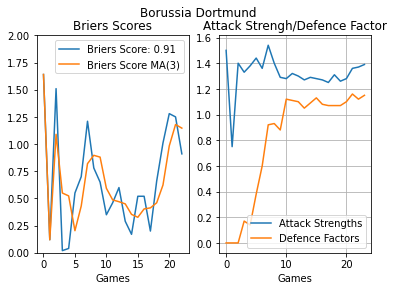

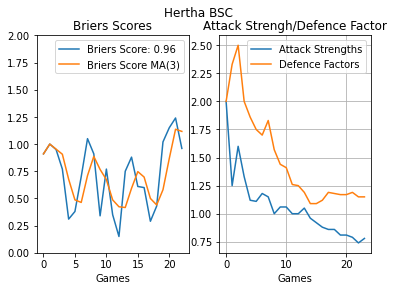

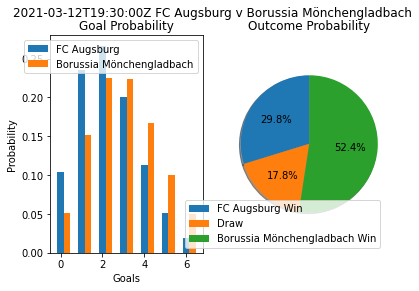

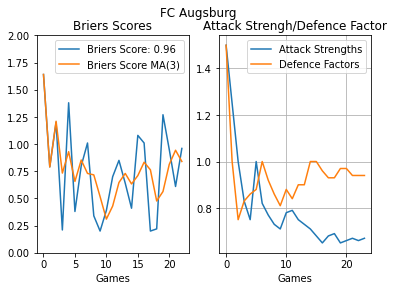

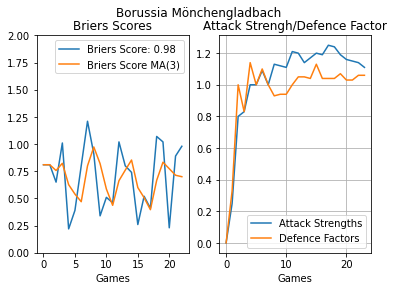

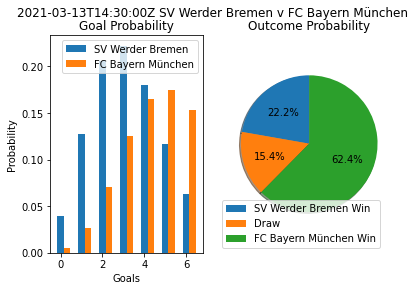

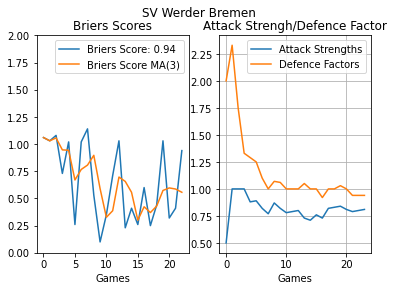

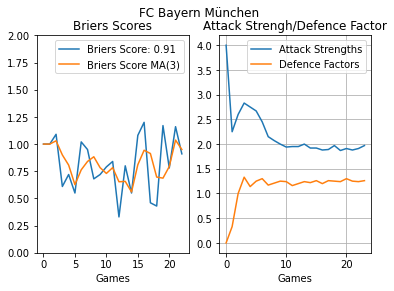

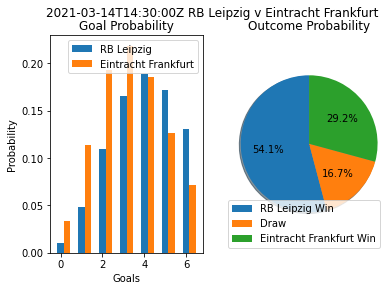

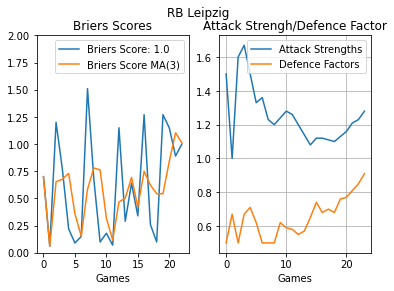

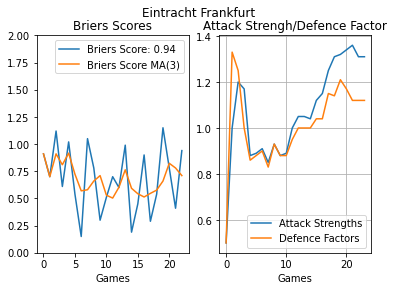

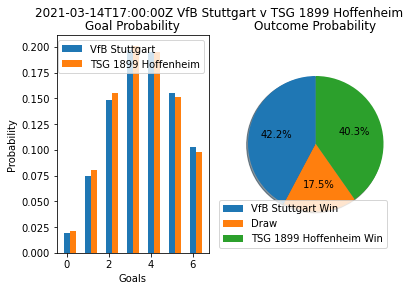

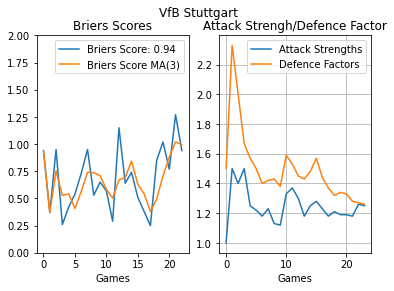

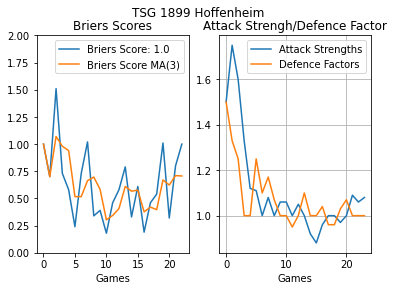

In [5]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Brazilian Série A

In [6]:
footy, fixtures = process_competition_page('BSA')
show_league_table(footy)

                  team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0          SC Internacional  60  43  18  18  17   69  1.33  1.10
1               CR Flamengo  65  54  18  18  11   68  1.44  1.38
2              São Paulo FC  57  45  18  18  12   63  1.27  1.15
3                CA Mineiro  59  33  18  18  26   62  1.31  0.85
4             Fluminense FC  52  37  18  18  15   60  1.16  0.95
5              SE Palmeiras  50  33  18  18  17   57  1.11  0.85
6               Grêmio FBPA  52  42  18  18  10   56  1.16  1.08
7                 Santos FC  51  39  18  18  12   53  1.13  1.00
8             CA Paranaense  36  31  18  18   5   50  0.80  0.79
9             RB Bragantino  49  35  18  18  14   49  1.09  0.90
10  SC Corinthians Paulista  45  39  18  18   6   49  1.00  1.00
11            AC Goianiense  36  35  18  18   1   46  0.80  0.90
12                 Ceará SC  50  54  18  18  -4   46  1.11  1.38
13                SC Recife  29  32  18  18  -3   42  0.64  0.82
14             Fortaleza 

## Upcoming Fixtures

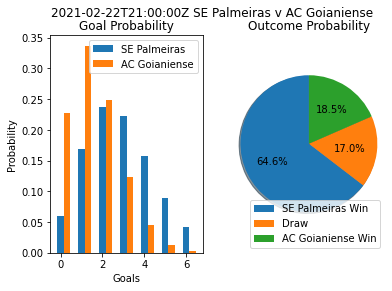

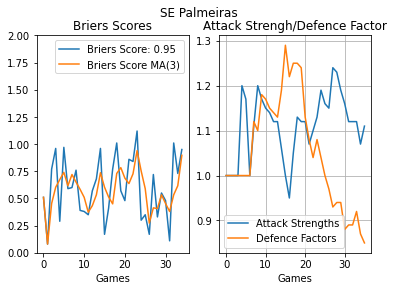

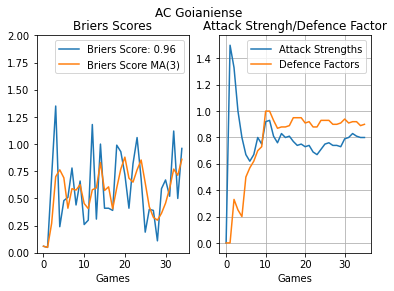

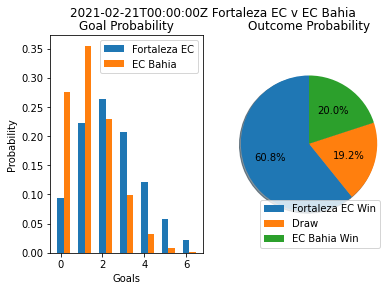

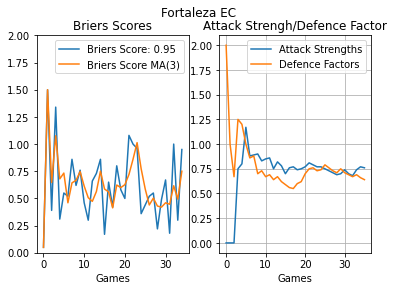

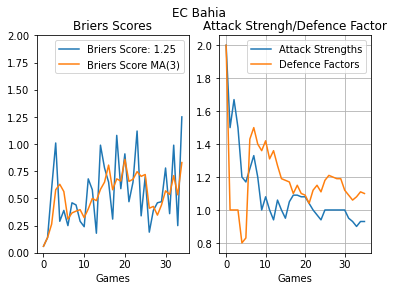

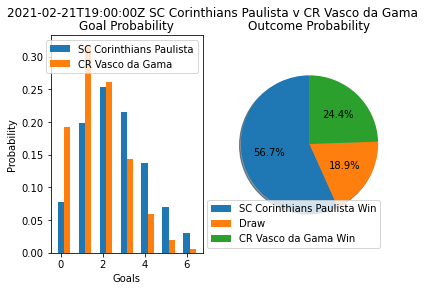

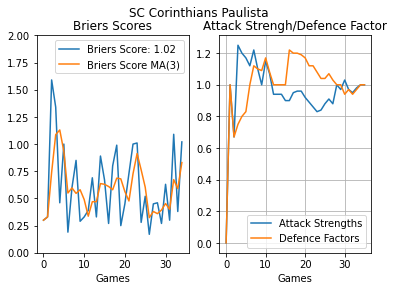

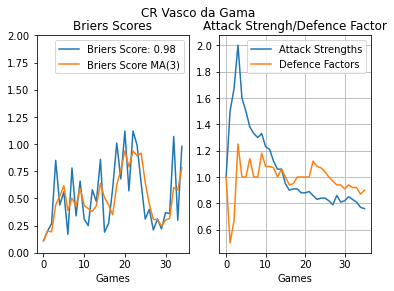

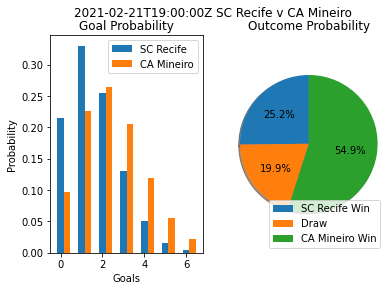

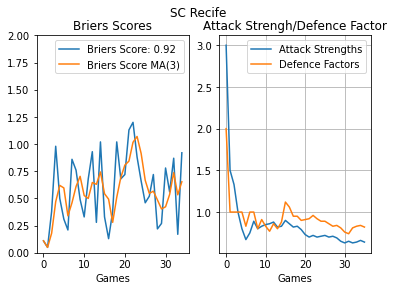

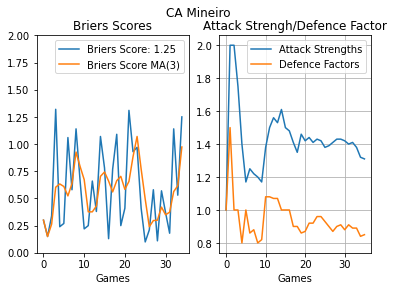

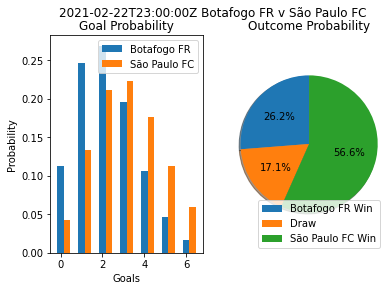

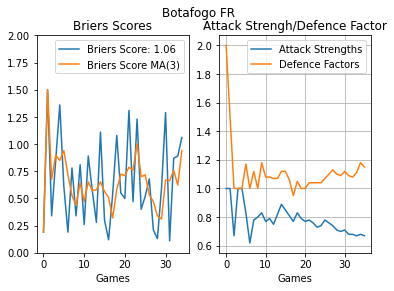

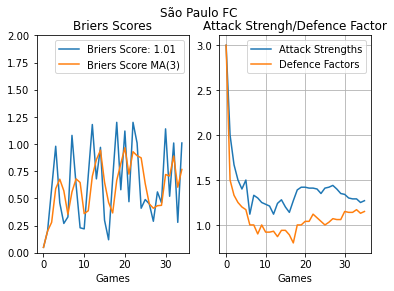

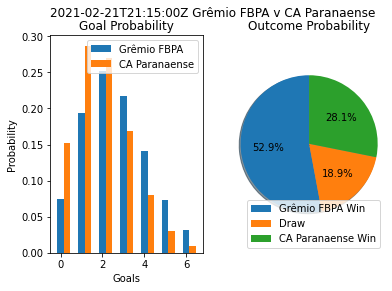

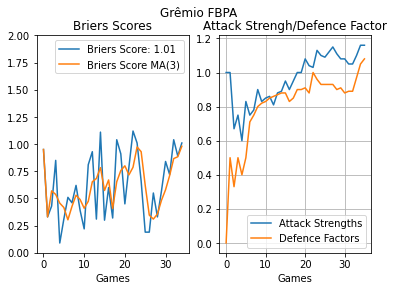

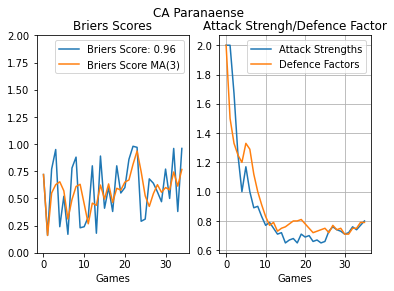

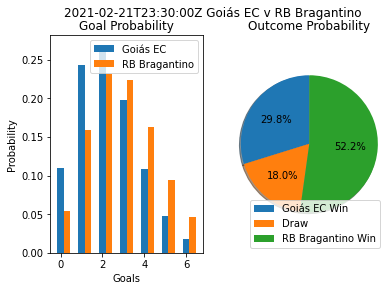

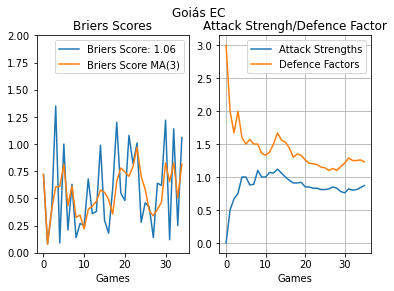

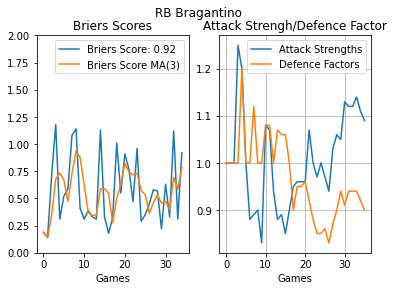

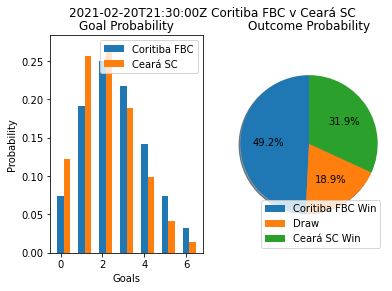

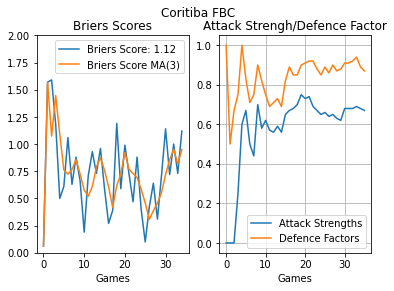

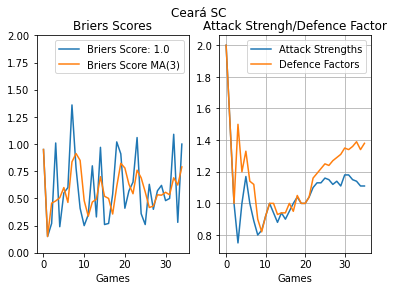

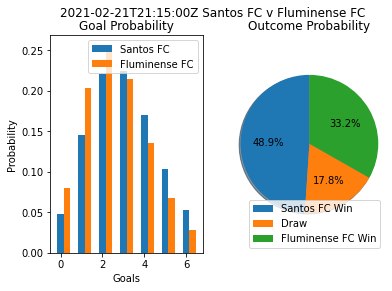

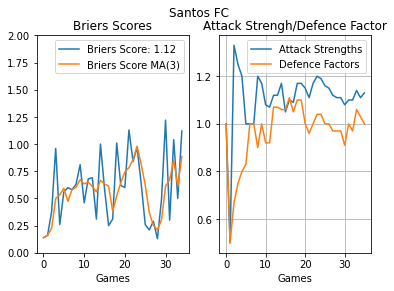

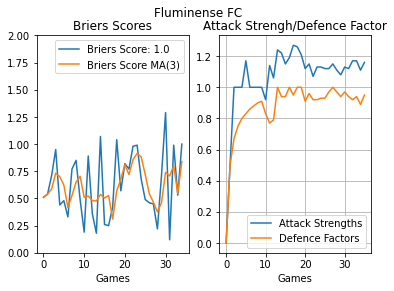

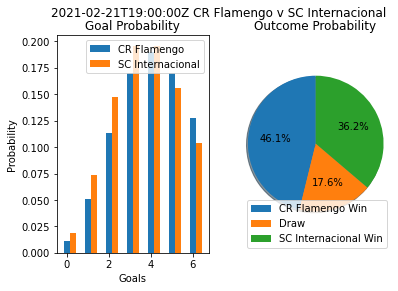

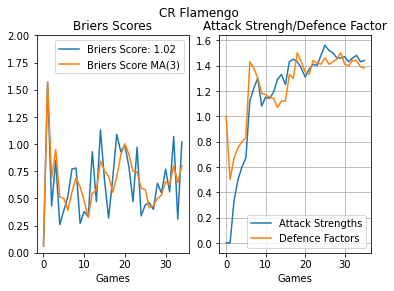

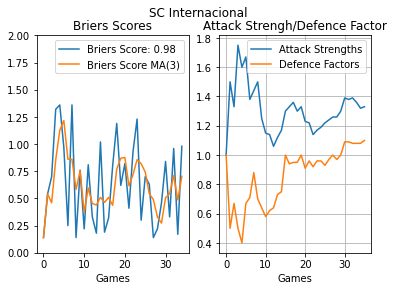

In [7]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Dutch Eredivisie

In [8]:
footy, fixtures = process_competition_page('DED')
show_league_table(footy)

              team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0              AFC Ajax  76  50  12  12  26   60  2.00  1.39
1                   PSV  58  38  12  13  20   54  1.53  1.06
2                    AZ  57  49  12  13   8   49  1.50  1.36
3           SBV Vitesse  41  26  13  12  15   48  1.08  0.72
4   Feyenoord Rotterdam  52  32  12  13  20   46  1.37  0.89
5          FC Groningen  32  25  13  12   7   42  0.84  0.69
6            FC Utrecht  38  34  13  11   4   37  1.00  0.94
7         FC Twente '65  40  41  13  12  -1   36  1.05  1.14
8         SC Heerenveen  35  27  12  13   8   33  0.92  0.75
9       Heracles Almelo  28  23  13  12   5   32  0.74  0.64
10      Fortuna Sittard  36  42  13  12  -6   31  0.95  1.17
11     Sparta Rotterdam  34  39  12  13  -5   27  0.89  1.08
12           PEC Zwolle  33  32  12  13   1   26  0.87  0.89
13         RKC Waalwijk  23  27  13  12  -4   23  0.61  0.75
14            VVV Venlo  37  54  12  13 -17   22  0.97  1.50
15    Willem II Tilburg 

## Upcoming Fixtures

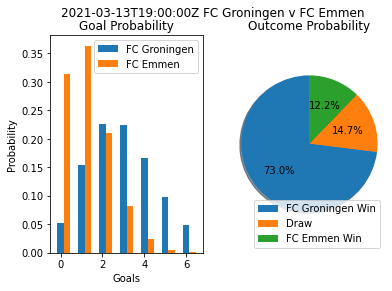

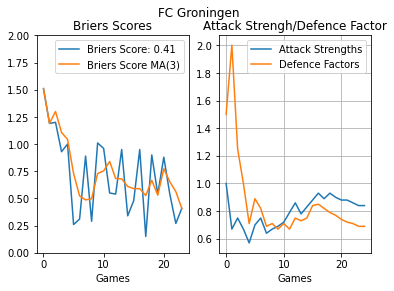

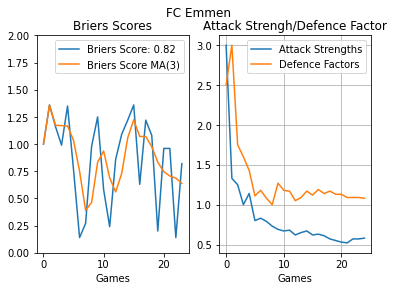

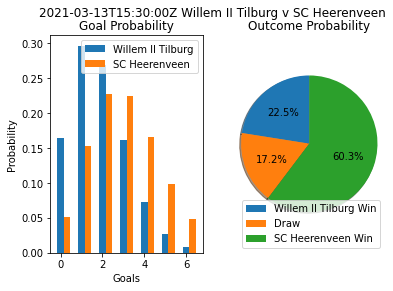

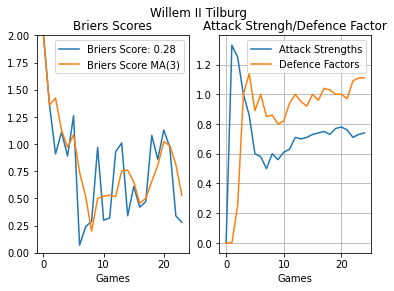

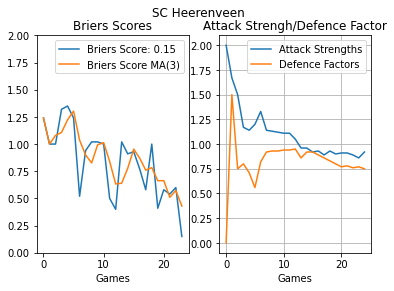

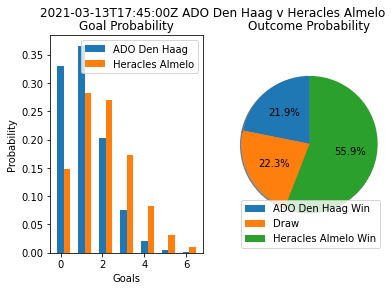

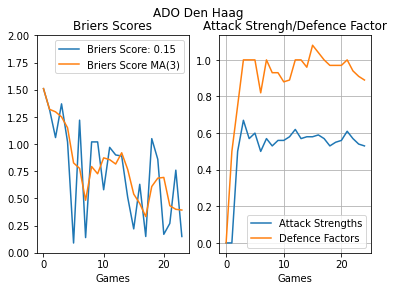

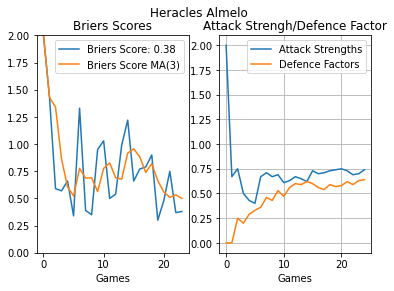

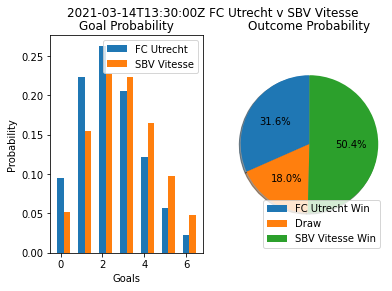

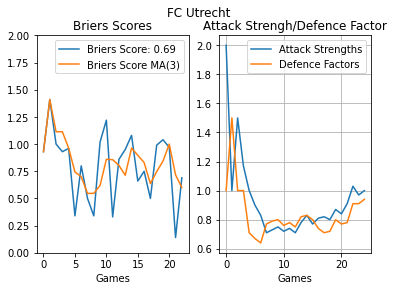

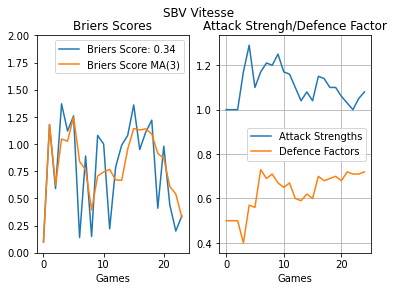

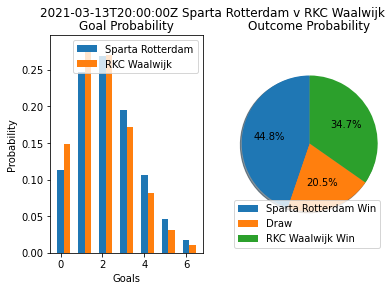

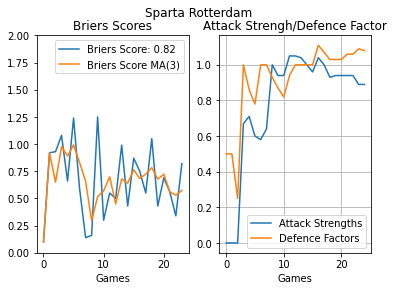

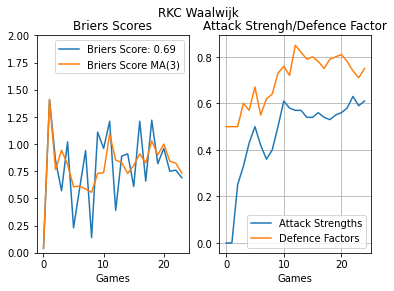

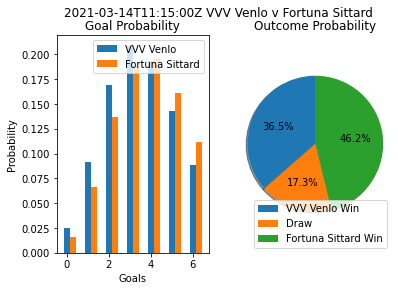

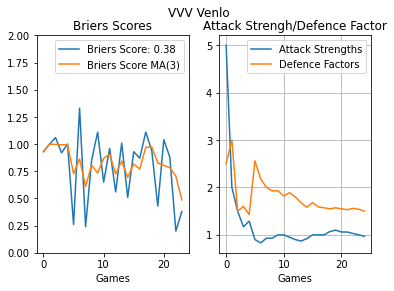

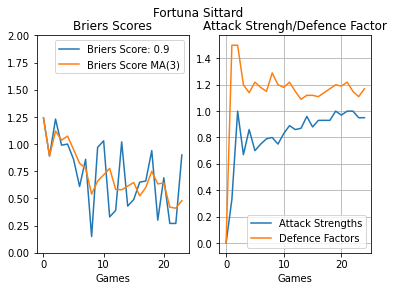

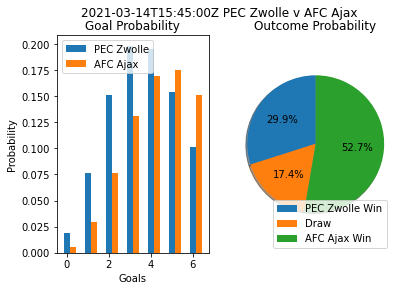

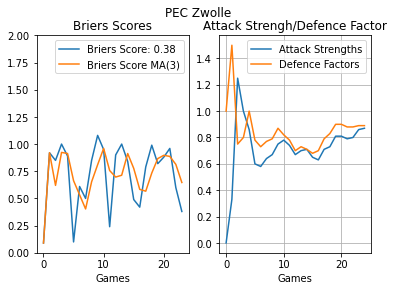

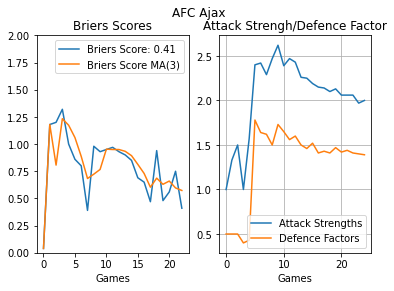

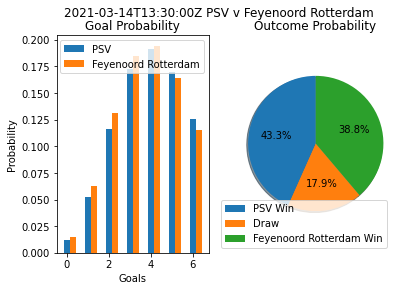

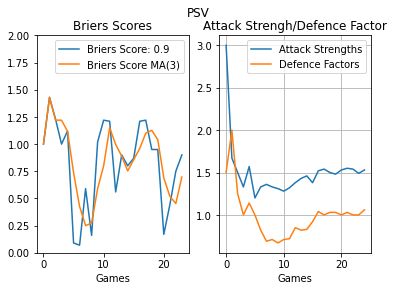

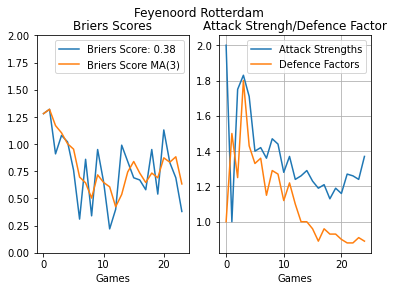

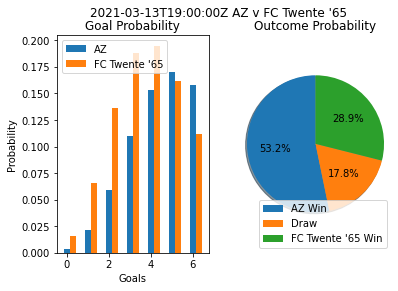

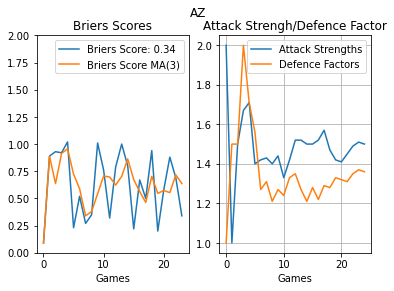

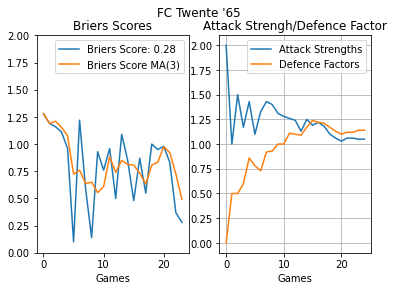

In [9]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# English Championship

In [10]:
footy, fixtures = process_competition_page('ELC')
show_league_table(footy)

                 team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0          Norwich City FC  51  34  18  17  17   76  1.31  0.97
1               Watford FC  46  23  18  17  23   66  1.18  0.66
2         Swansea City AFC  44  31  18  16  13   66  1.13  0.89
3             Brentford FC  61  45  17  17  16   63  1.56  1.29
4               Reading FC  49  41  18  17   8   60  1.26  1.17
5              Barnsley FC  42  36  18  17   6   58  1.08  1.03
6          AFC Bournemouth  50  38  17  18  12   56  1.28  1.09
7          Cardiff City FC  53  41  17  18  12   54  1.36  1.17
8         Middlesbrough FC  41  39  17  18   2   50  1.05  1.11
9            Stoke City FC  41  37  18  17   4   48  1.05  1.06
10             Millwall FC  34  33  18  17   1   46  0.87  0.94
11  Queens Park Rangers FC  35  36  17  17  -1   46  0.90  1.03
12         Bristol City FC  36  41  18  17  -5   45  0.92  1.17
13     Blackburn Rovers FC  49  44  17  18   5   44  1.26  1.26
14           Luton Town FC  28  27  16  

## Upcoming Fixtures

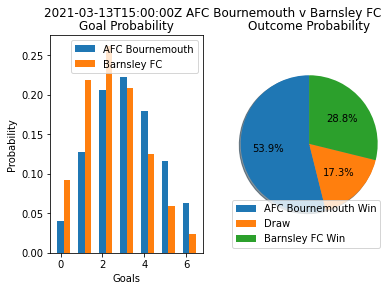

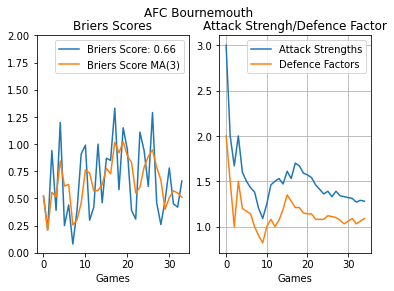

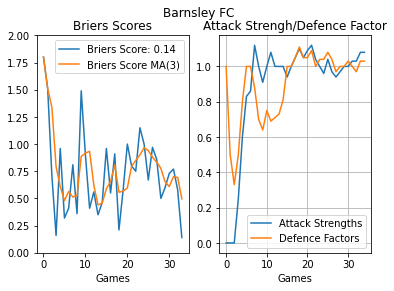

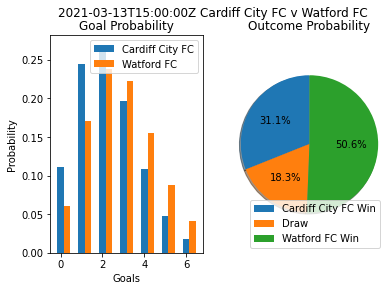

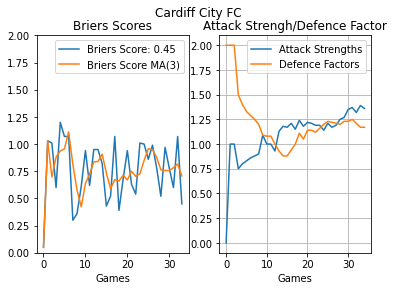

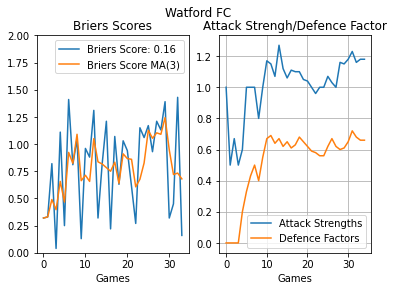

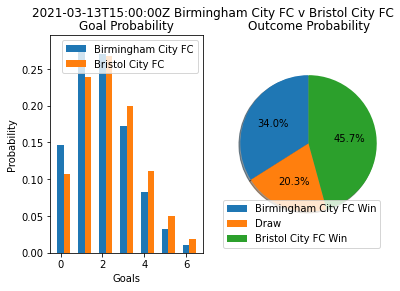

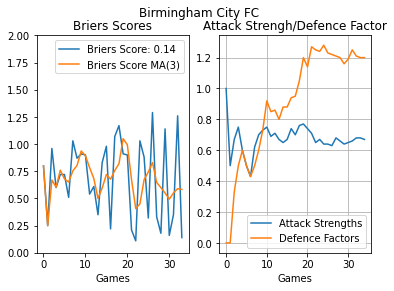

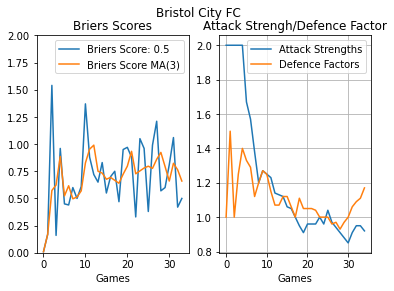

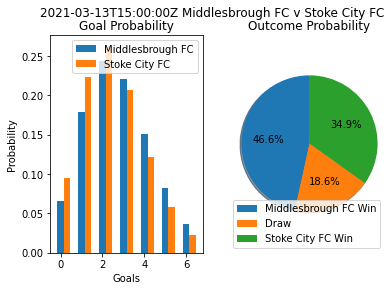

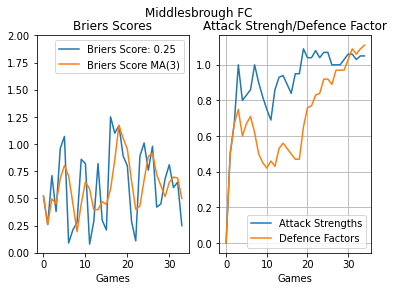

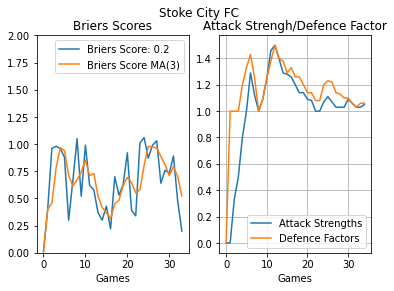

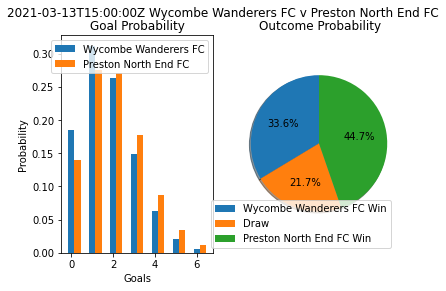

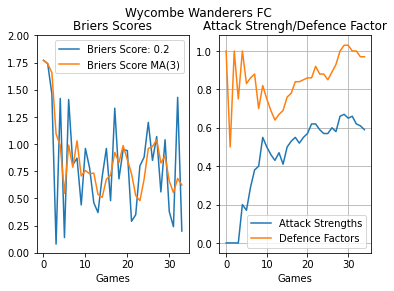

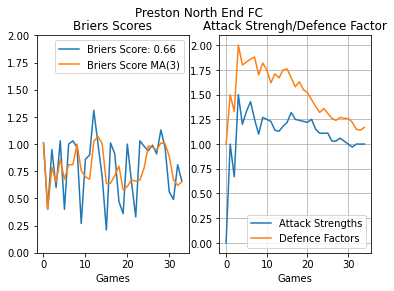

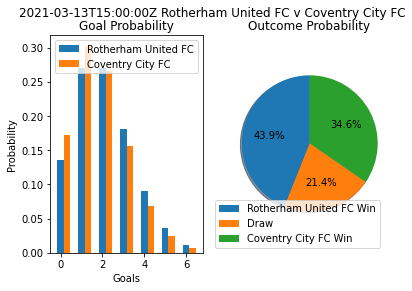

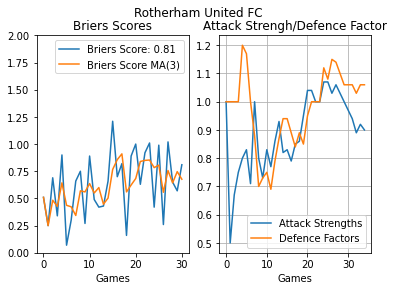

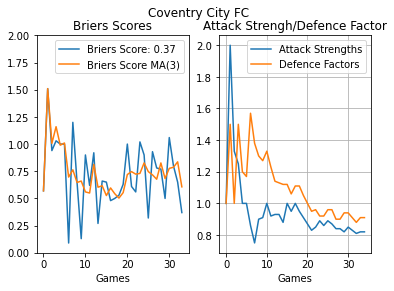

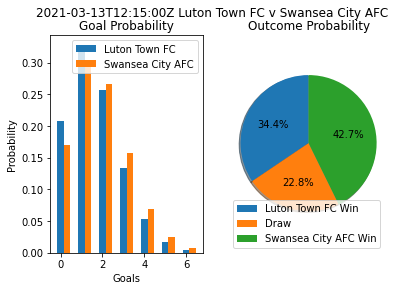

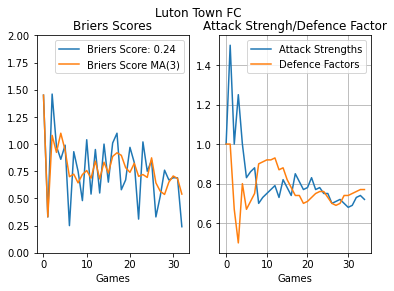

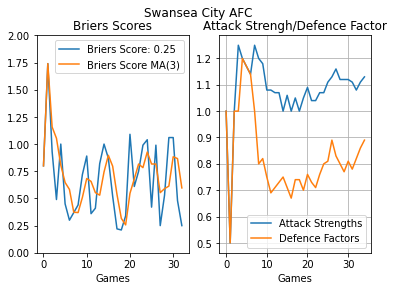

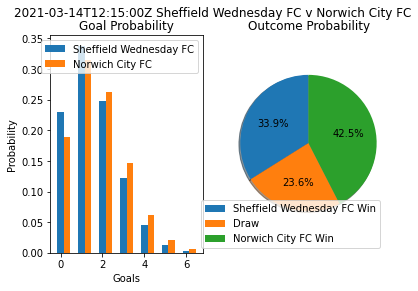

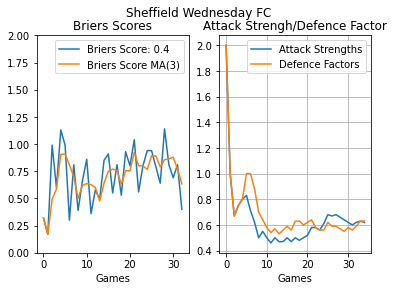

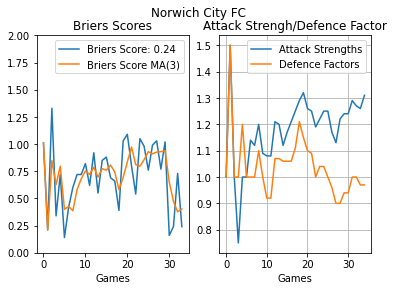

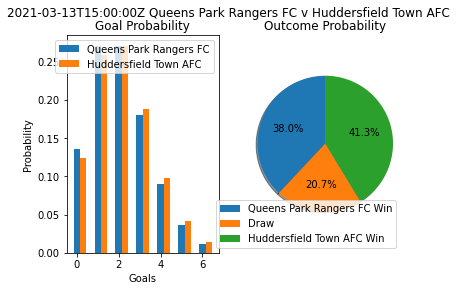

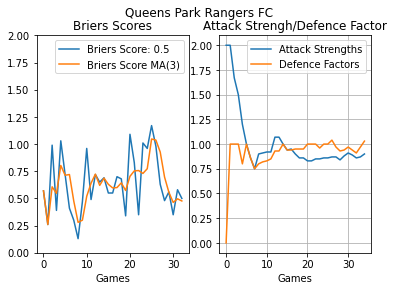

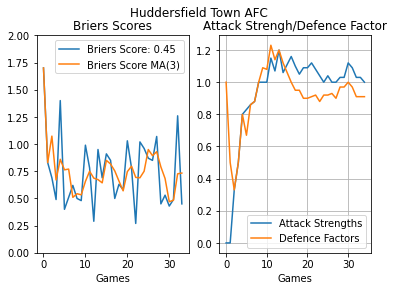

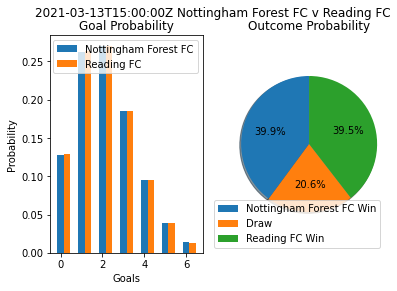

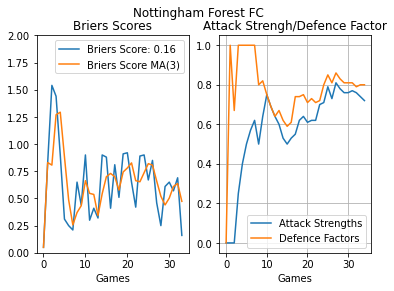

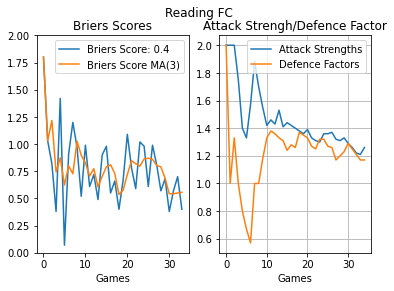

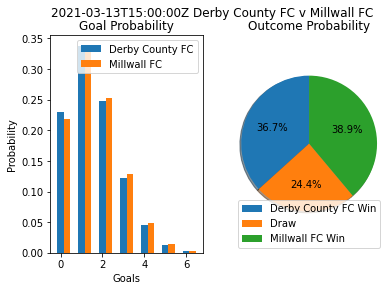

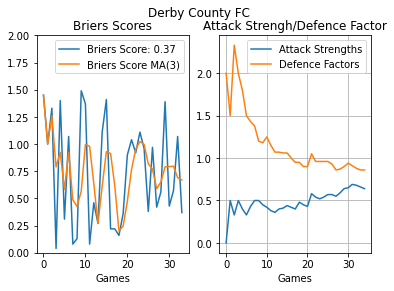

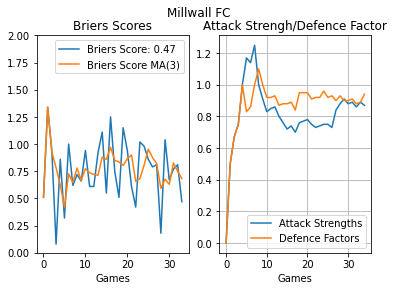

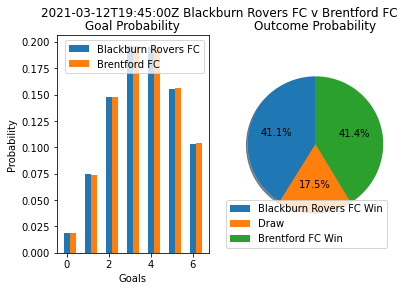

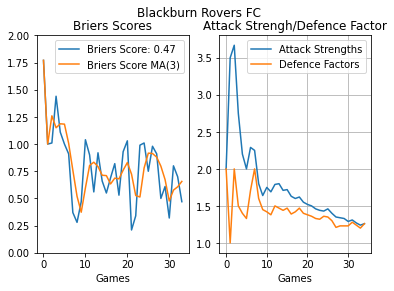

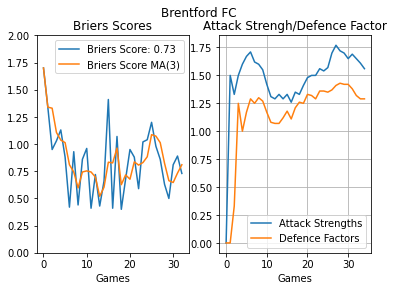

In [11]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# French Ligue 1

In [12]:
footy, fixtures = process_competition_page('FL1')
show_league_table(footy)

                   team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0                  Lille OSC  49  33  15  13  16   62  1.29  0.89
1     Paris Saint-Germain FC  62  36  14  14  26   60  1.63  0.97
2         Olympique Lyonnais  56  39  14  14  17   59  1.47  1.05
3               AS Monaco FC  56  41  14  14  15   55  1.47  1.11
4        Racing Club de Lens  42  41  13  15   1   44  1.11  1.11
5     Olympique de Marseille  35  32  14  14   3   42  0.92  0.86
6                    FC Metz  33  31  14  14   2   41  0.87  0.84
7            Montpellier HSC  44  46  15  13  -2   40  1.16  1.24
8                 Angers SCO  33  37  13  15  -4   39  0.87  1.00
9      Stade Rennais FC 1901  33  36  14  14  -3   38  0.87  0.97
10                  OGC Nice  35  44  14  14  -9   35  0.92  1.19
11         Stade Brestois 29  42  38  14  14   4   34  1.11  1.03
12            Stade de Reims  34  35  13  15  -1   34  0.89  0.95
13      RC Strasbourg Alsace  36  38  14  14  -2   33  0.95  1.03
14  FC Gir

## Upcoming Fixtures

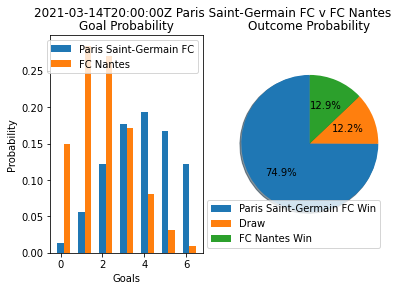

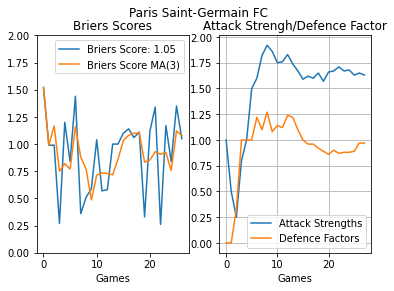

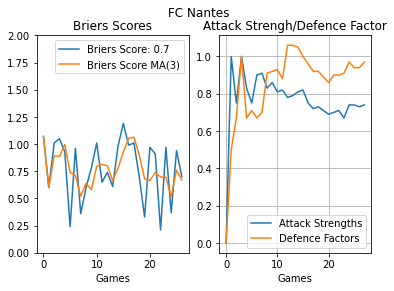

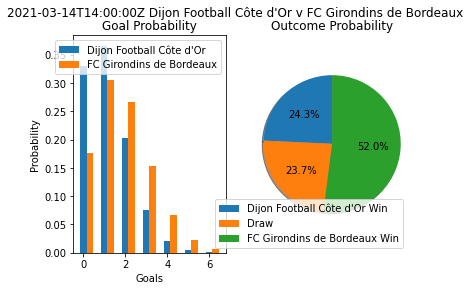

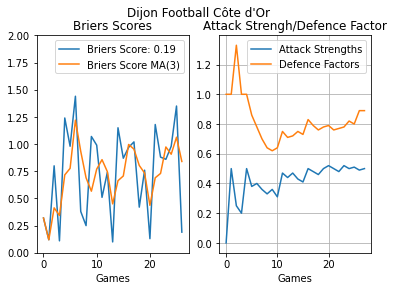

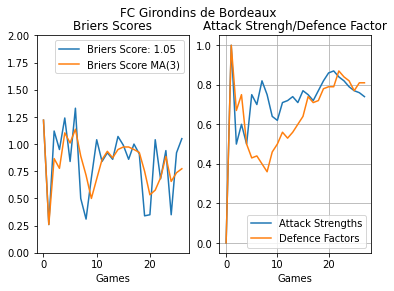

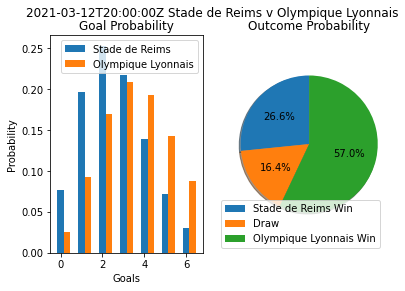

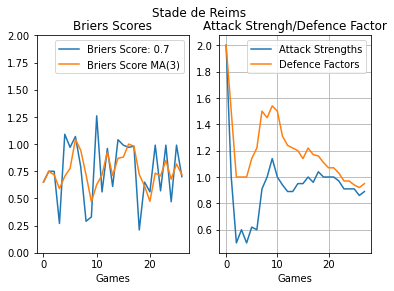

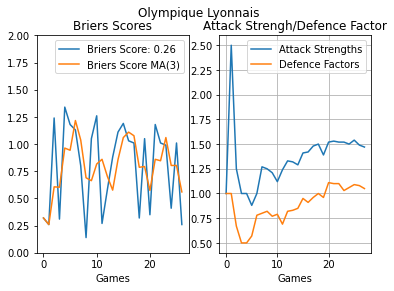

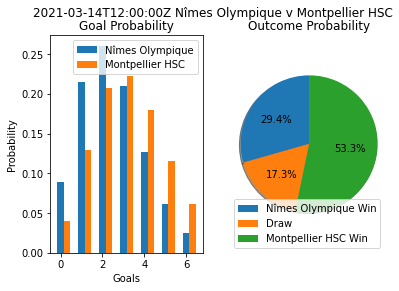

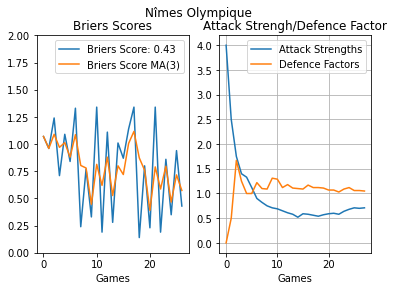

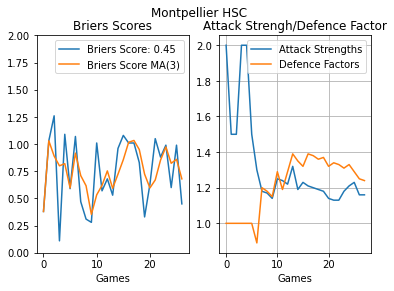

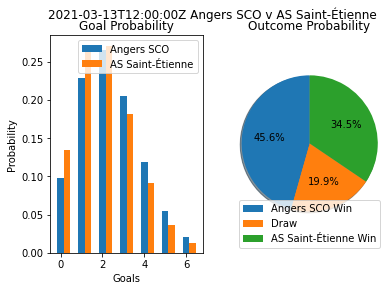

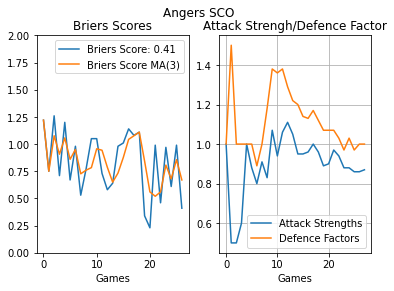

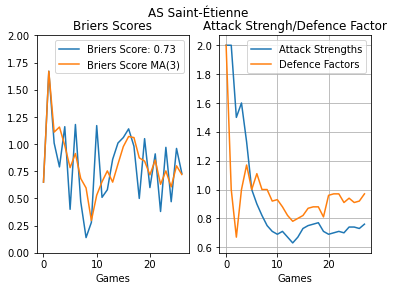

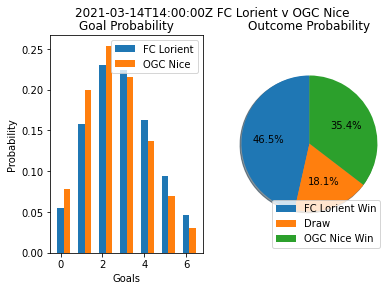

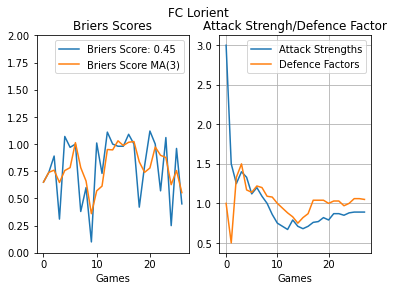

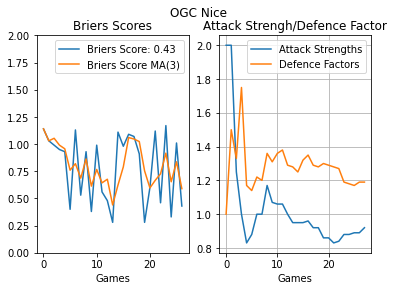

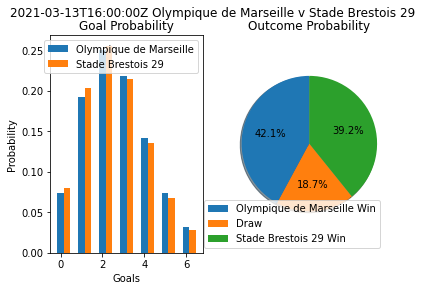

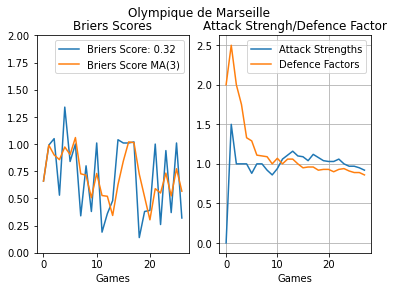

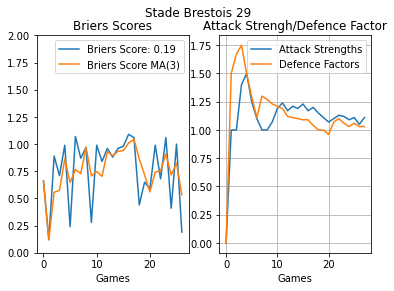

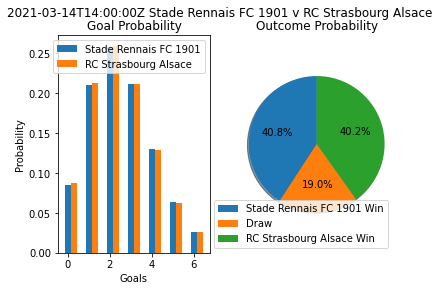

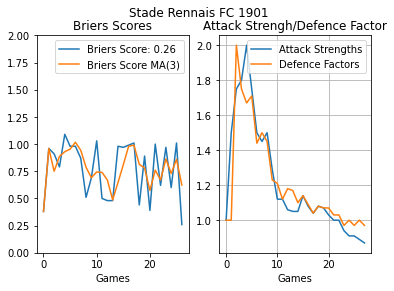

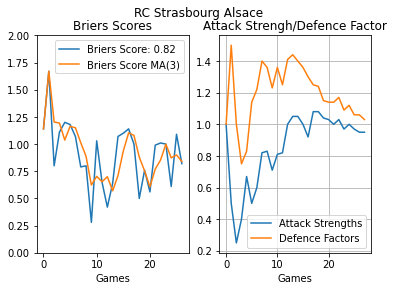

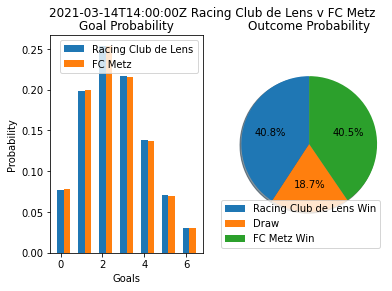

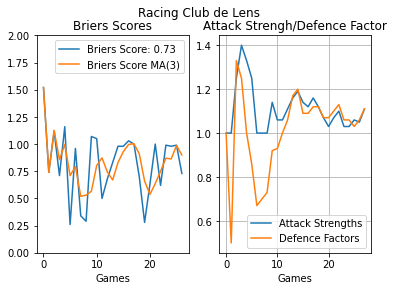

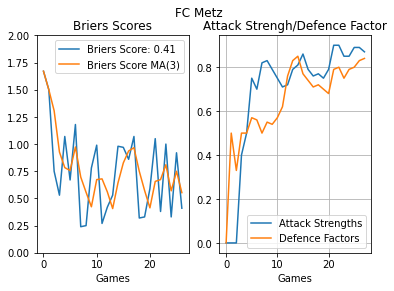

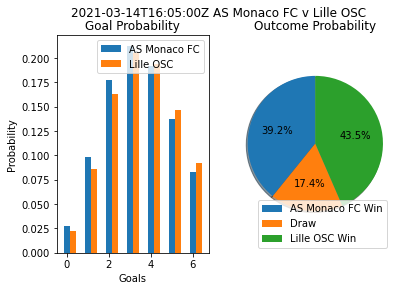

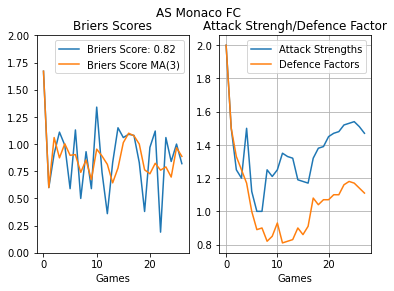

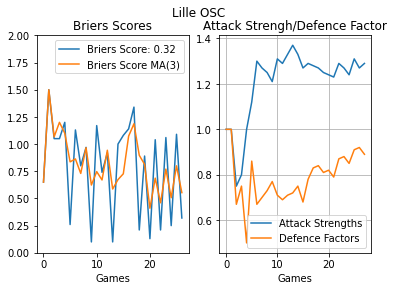

In [13]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Spanish Primera Division

In [14]:
footy, fixtures = process_competition_page('PD')
show_league_table(footy)

                  team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0   Club Atlético de Madrid  50  30  14  12  20   62  1.56  1.00
1              FC Barcelona  57  38  13  13  19   56  1.78  1.27
2            Real Madrid CF  44  31  12  14  13   54  1.38  1.03
3                Sevilla FC  35  25  12  13  10   48  1.09  0.83
4   Real Sociedad de Fútbol  43  30  13  13  13   45  1.34  1.00
5       Real Betis Balompié  36  34  13  13   2   42  1.12  1.13
6             Villarreal CF  34  30  13  13   4   37  1.06  1.00
7             Athletic Club  37  27  13  13  10   33  1.16  0.90
8                Granada CF  32  29  13  13   3   33  1.00  0.97
9          RC Celta de Vigo  34  34  12  14   0   33  1.06  1.13
10               Levante UD  35  32  13  13   3   32  1.09  1.07
11              Valencia CF  32  27  13  13   5   30  1.00  0.90
12               CA Osasuna  23  29  13  13  -6   28  0.72  0.97
13                 Cádiz CF  22  32  14  12 -10   28  0.69  1.07
14                Getafe 

## Upcoming Fixtures

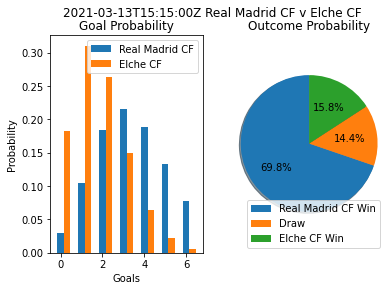

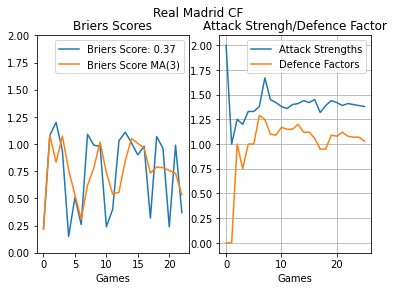

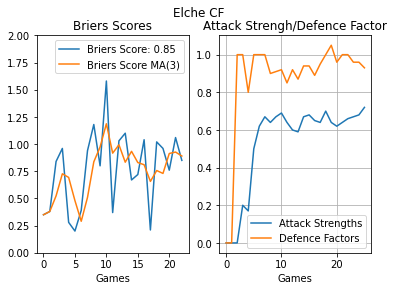

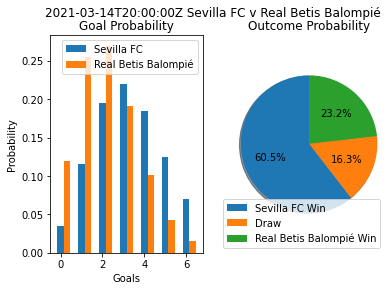

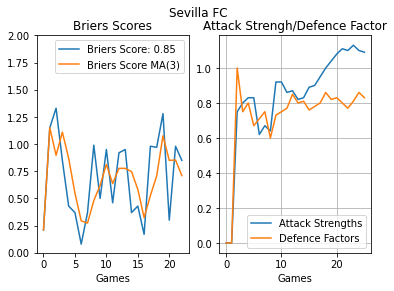

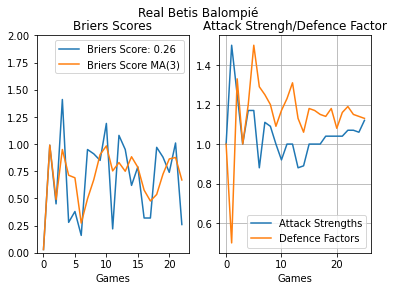

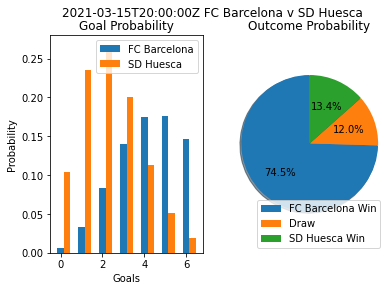

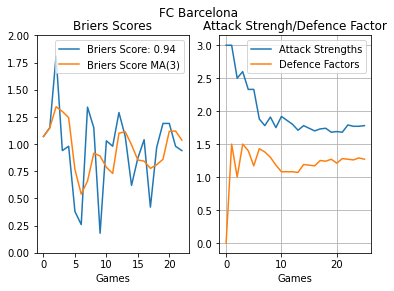

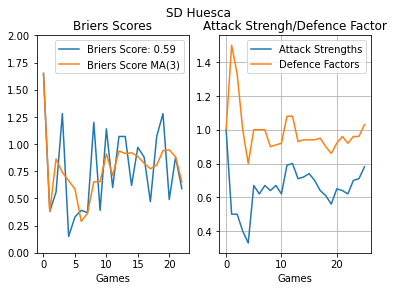

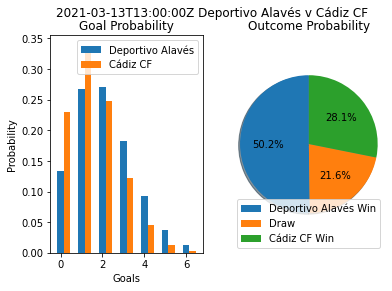

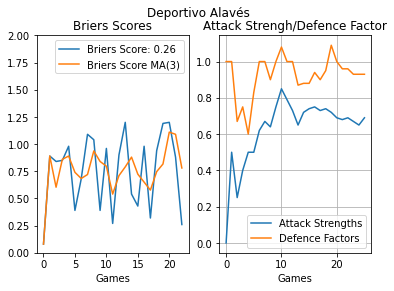

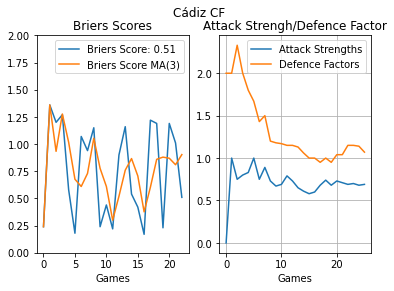

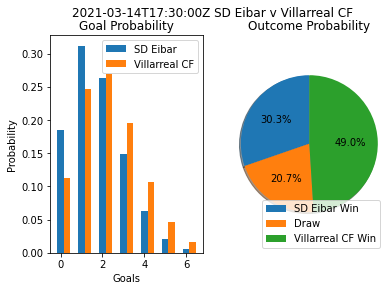

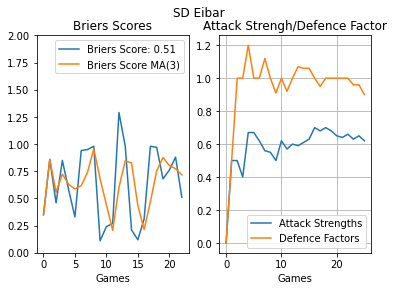

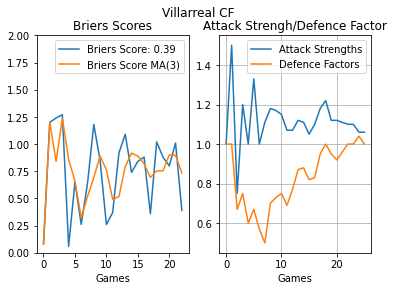

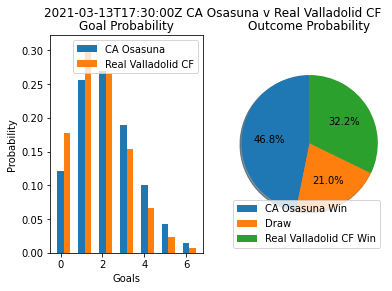

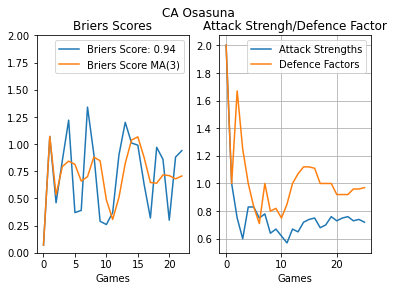

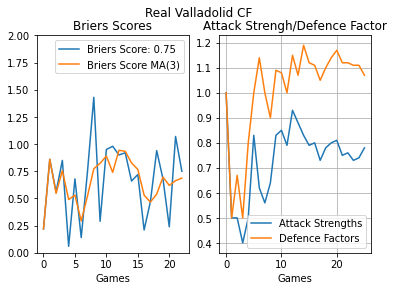

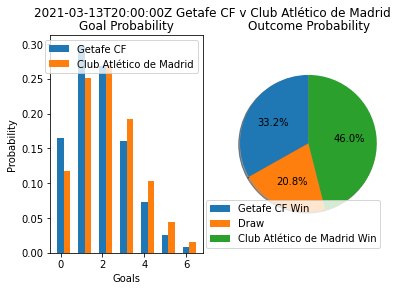

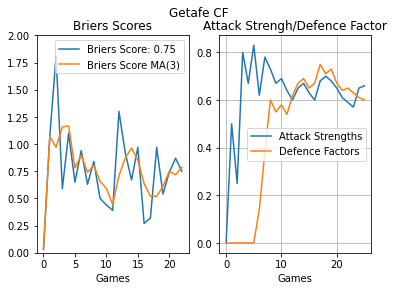

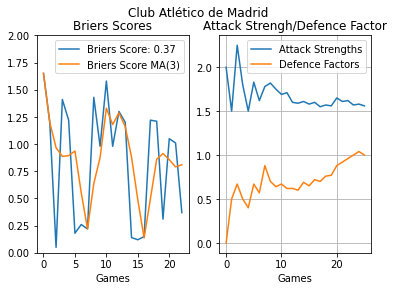

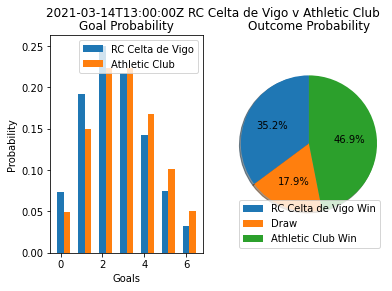

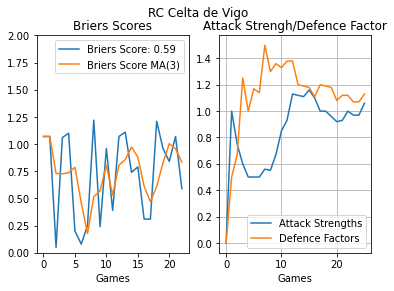

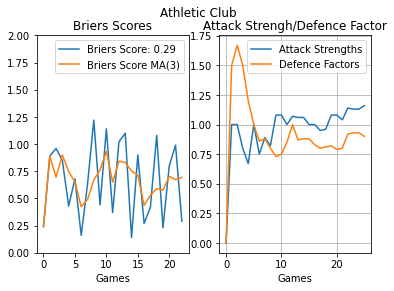

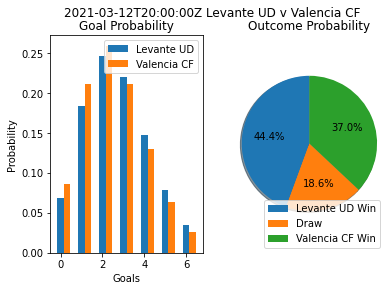

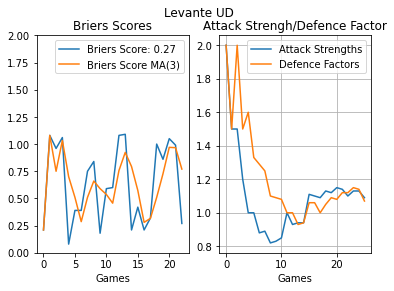

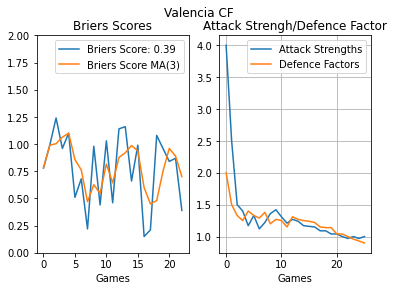

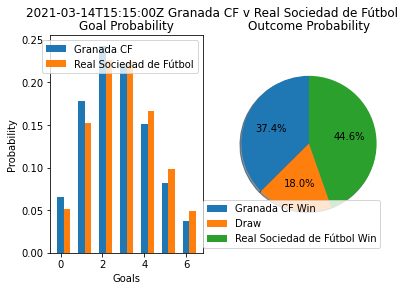

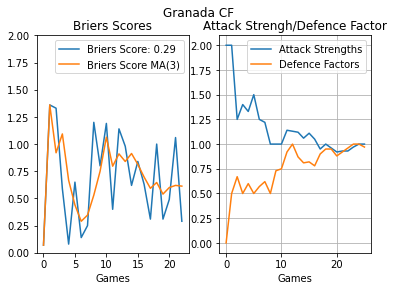

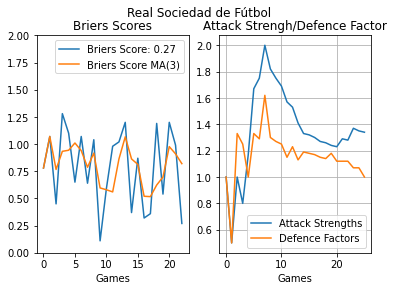

In [15]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# English Premier League

In [16]:
footy, fixtures = process_competition_page('PL')
show_league_table(footy)

                     team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0           Manchester City FC  59  39  15  14  20   68  1.64  1.08
1         Manchester United FC  55  46  13  15   9   54  1.53  1.28
2            Leicester City FC  48  47  13  15   1   53  1.33  1.31
3                   Chelsea FC  44  30  14  15  14   51  1.22  0.83
4           West Ham United FC  42  34  14  13   8   48  1.17  0.94
5                   Everton FC  40  43  14  14  -3   46  1.11  1.19
6                 Liverpool FC  47  43  15  13   4   43  1.31  1.19
7         Tottenham Hotspur FC  45  34  14  12  11   42  1.25  0.94
8               Aston Villa FC  39  35  12  15   4   41  1.08  0.97
9                   Arsenal FC  35  33  13  14   2   38  0.97  0.92
10           Crystal Palace FC  31  37  15  14  -6   37  0.86  1.03
11             Leeds United FC  43  41  14  14   2   36  1.19  1.14
12  Wolverhampton Wanderers FC  28  27  13  15   1   35  0.78  0.75
13              Southampton FC  33  32  13  14  

## Upcoming Fixtures

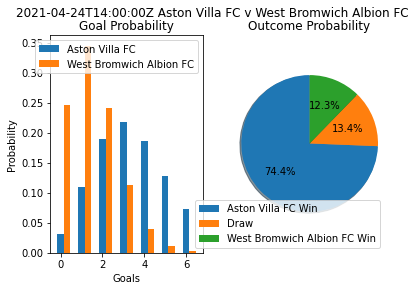

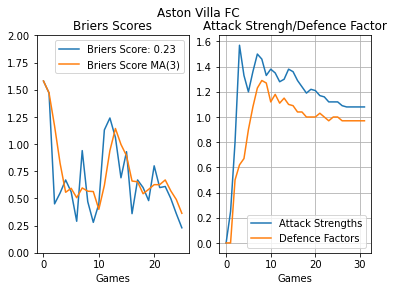

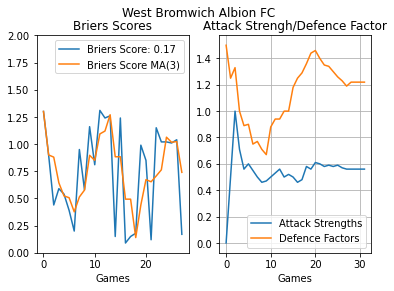

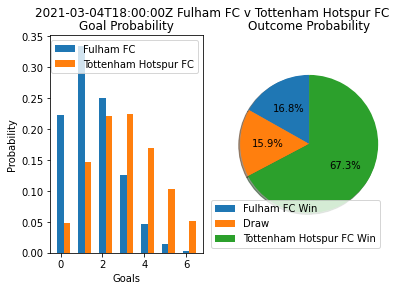

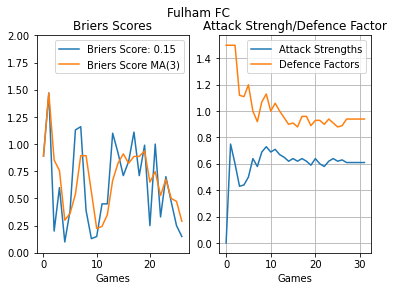

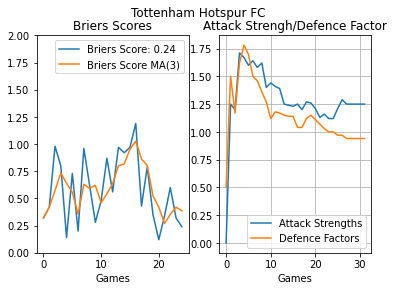

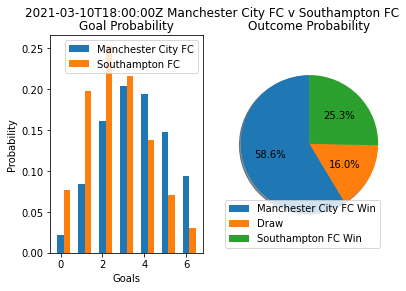

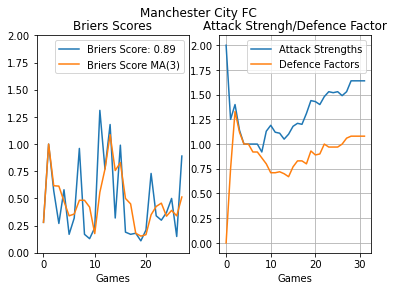

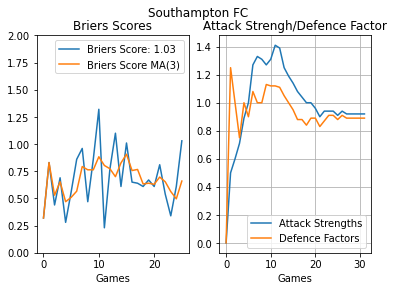

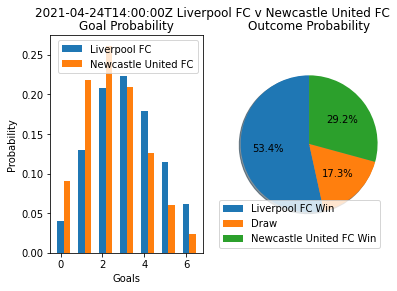

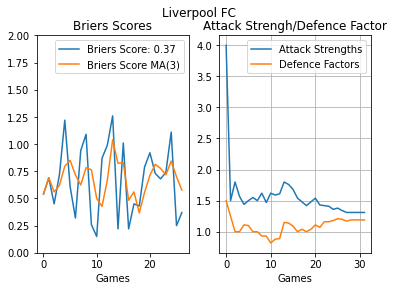

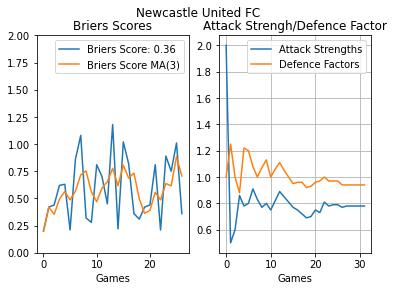

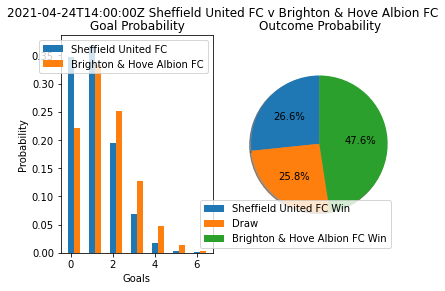

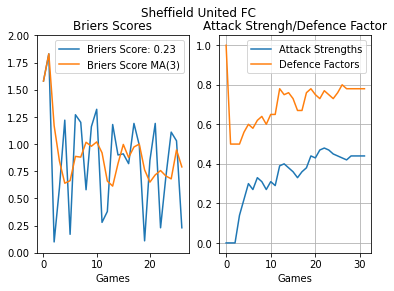

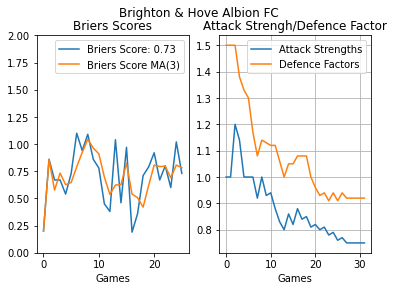

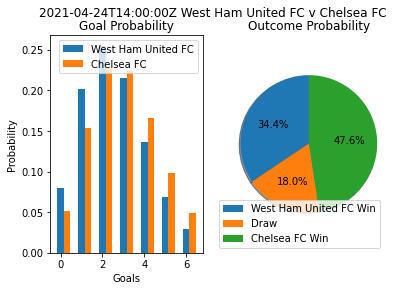

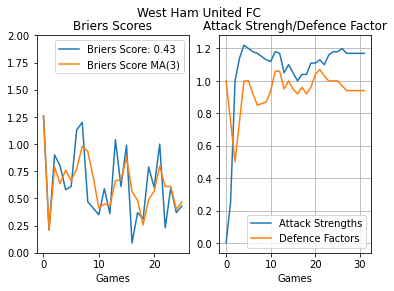

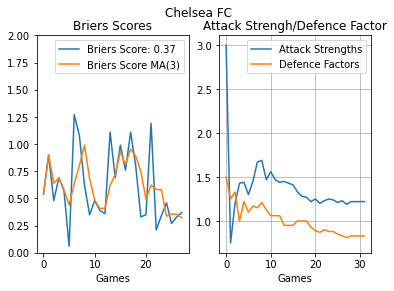

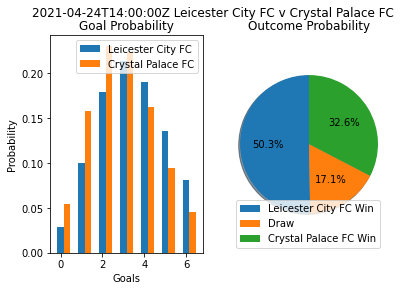

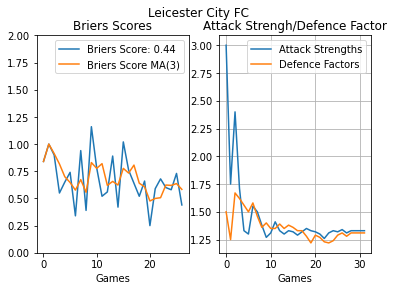

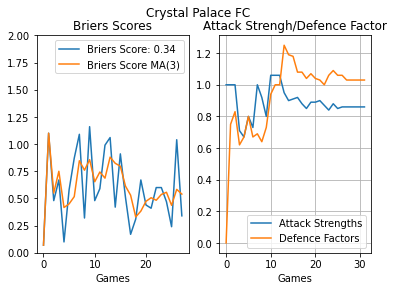

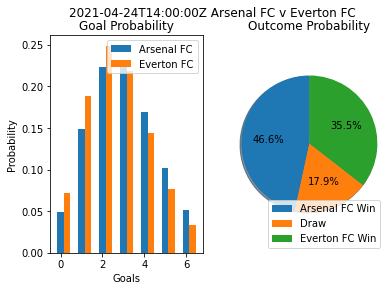

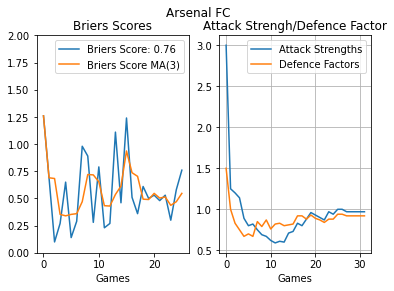

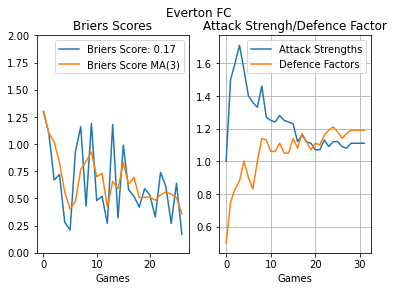

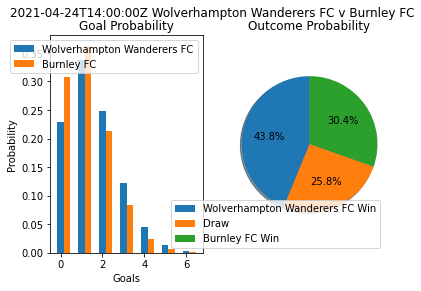

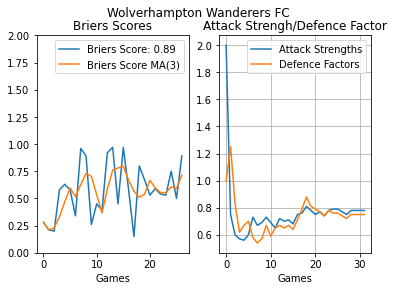

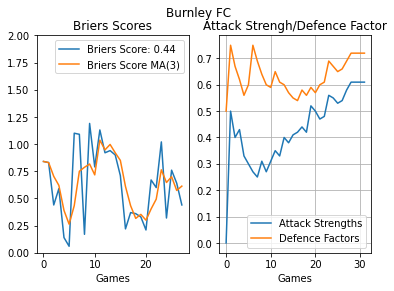

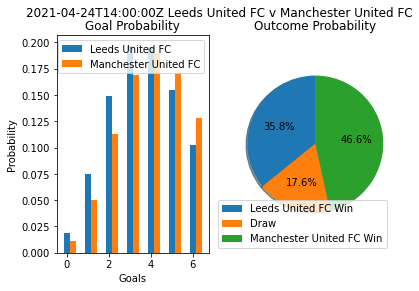

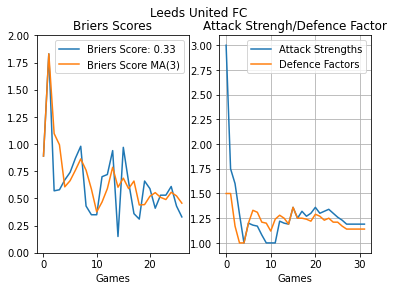

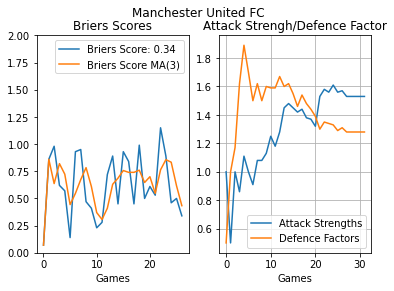

In [17]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Portuguese  Primeira Liga

In [18]:
footy, fixtures = process_competition_page('PPL')
show_league_table(footy)

                     team_name  GF  GA  HG  AG  GD  PTS    AS    DF
0   Sporting Clube de Portugal  44  28  11  11  16   58  1.69  1.17
1      Sporting Clube de Braga  42  29  11  11  13   49  1.62  1.21
2                     FC Porto  47  35  11  11  12   48  1.81  1.46
3       Sport Lisboa e Benfica  38  26  11  11  12   45  1.46  1.08
4         FC Paços de Ferreira  30  21  11  11   9   41  1.15  0.88
5                   Vitória SC  27  30  11  11  -3   35  1.04  1.25
6                Moreirense FC  22  23  11  11  -1   29  0.85  0.96
7               CD Santa Clara  24  25  10  12  -1   28  0.92  1.04
8                   Rio Ave FC  18  17  11  11   1   25  0.69  0.71
9                   CD Tondela  22  18  11  11   4   24  0.85  0.75
10             Portimonense SC  21  15  11  11   6   23  0.81  0.62
11       Os Belenenses Futebol  13  16  12  10  -3   22  0.50  0.67
12                 CD Nacional  21  24  11  11  -3   21  0.81  1.00
13                 Boavista FC  24  30  11  11  

## Upcoming Fixtures

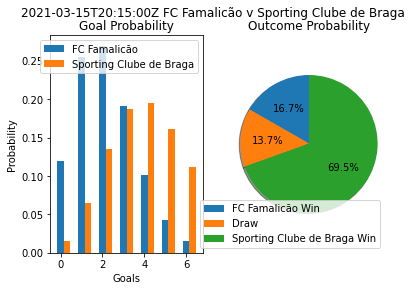

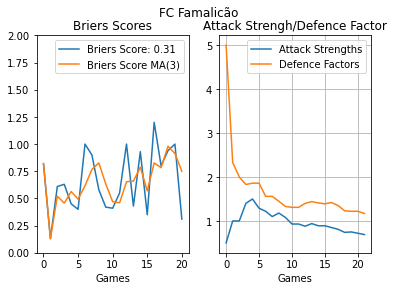

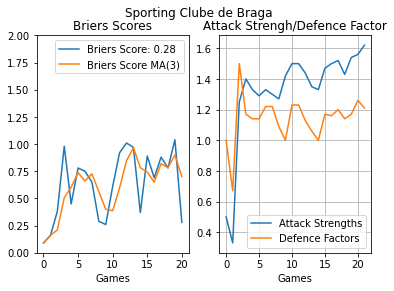

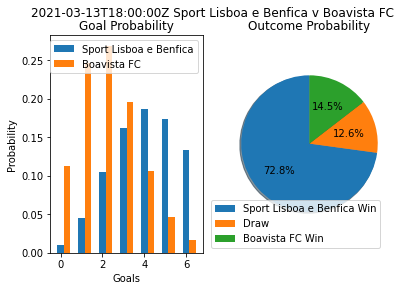

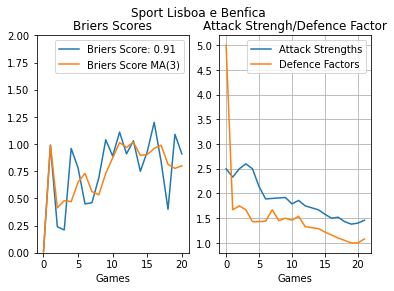

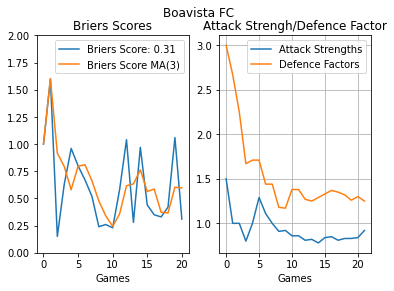

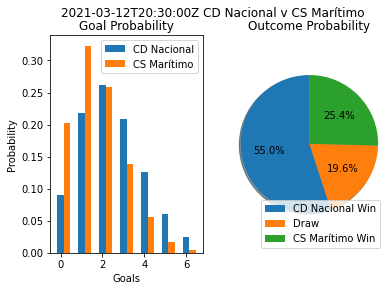

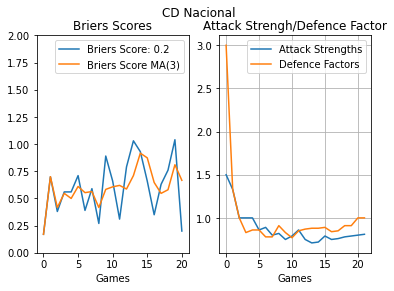

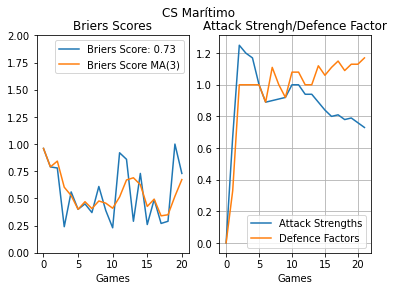

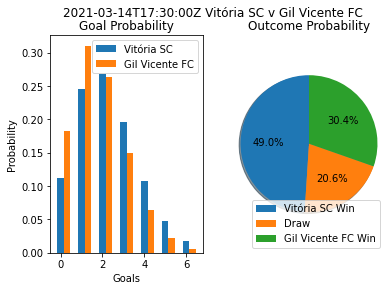

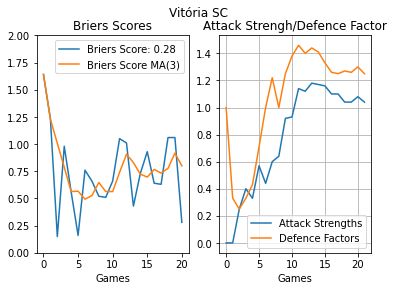

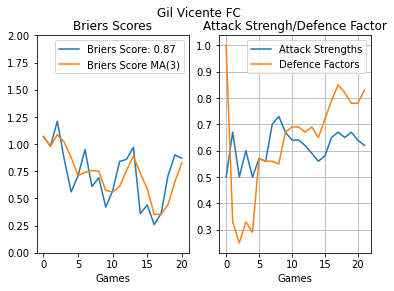

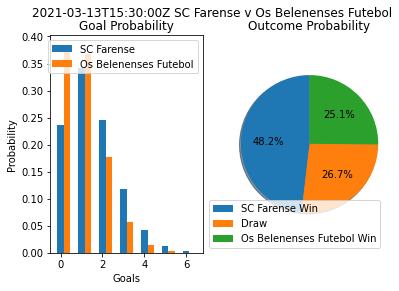

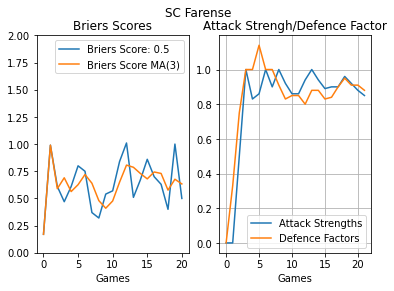

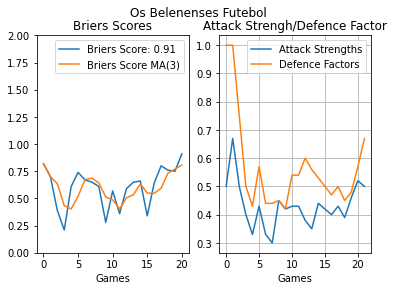

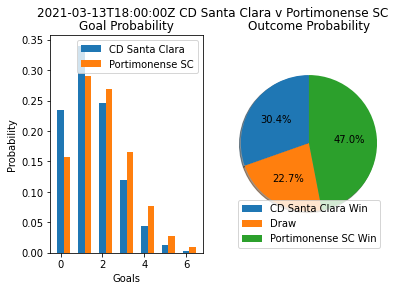

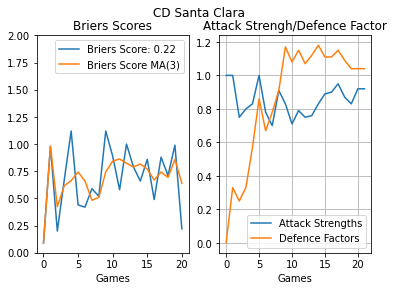

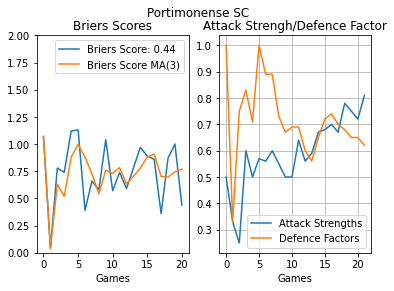

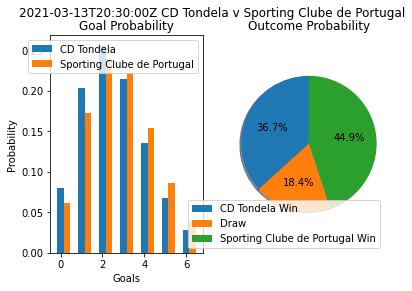

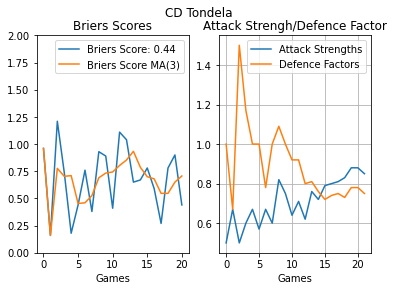

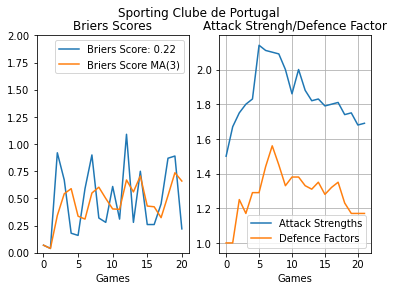

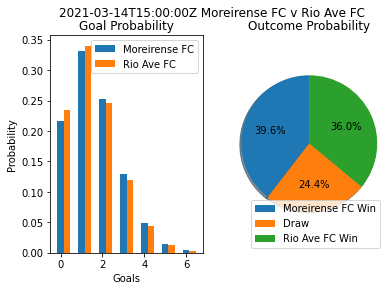

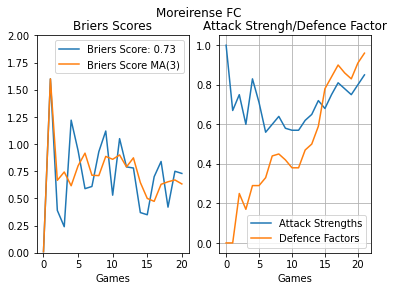

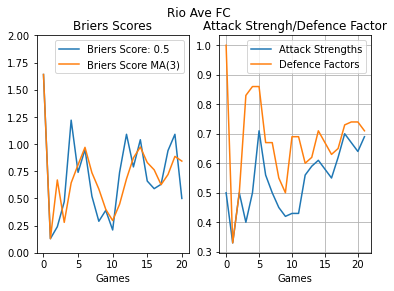

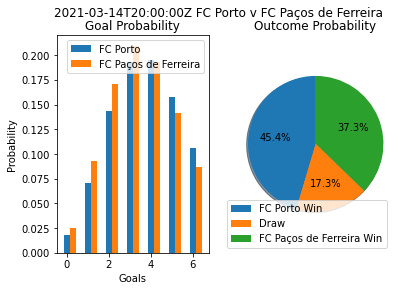

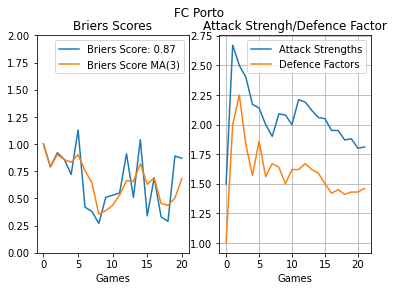

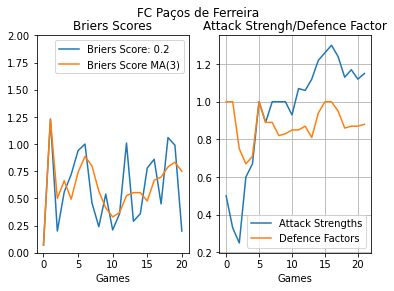

In [19]:
show_upcoming_fixtures(fixtures)

<div style="page-break-after: always; visibility: hidden"> 
\pagebreak 
</div>

# Italian Serie A

In [20]:
footy, fixtures = process_competition_page('SA')
show_league_table(footy)

ValueError: Calling https://api.football-data.org/v2/competitions/2019/matches returned a 429 status code

## Upcoming Fixtures

In [ ]:
show_upcoming_fixtures(fixtures)